In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset,TensorDataset
from autoencoder2 import Autoencoder2, reduce_dimensions2
import torchvision
from model2 import classification_model
import copy
import partition
from pca import PCADigitReducer
from training import train,test, train_fashion,test_fashion
from federated_learning import distribute_global_model, federated_averaging
from model4 import MultilayerPerceptron
import cluster2
from sklearn.metrics import precision_score, recall_score, f1_score
import time

# Data Preprocessing

In [2]:
n_epochs = 10
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01 # ev. 0.001
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [3]:
# training and testing data as dataloaders

train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.0,), (1,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.0,), (1,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

In [4]:
train_loader_pca = copy.copy(train_loader)
test_loader_pca = copy.copy(test_loader)

train_loader_auto = copy.copy(train_loader)
test_loader_auto = copy.copy(test_loader)

In [5]:
class CustomTensorDataset(TensorDataset):
    def __init__(self, *tensors):
        super().__init__(*tensors)
        self.data = tensors[0]
        self.targets = tensors[1] 

# Autoencoder

In [6]:
autoencoder2 = Autoencoder2()
auto2_criterion = nn.BCELoss()  
auto2_optimizer = optim.Adam(autoencoder2.parameters(), lr=0.001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
num_epochs = 5 # optimal nach vielen testen
for epoch in range(num_epochs):
    autoencoder2.train()
    train_loss = 0

    for images, _ in train_loader_auto:
        images = images.to(device)

        auto2_optimizer.zero_grad()
        outputs = autoencoder2(images)
        loss = auto2_criterion(outputs, images) 
        
        loss.backward()
        auto2_optimizer.step()

        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader_auto)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_train_loss:.4f}")

Epoch [1/5], Loss: 0.1125
Epoch [2/5], Loss: 0.0847
Epoch [3/5], Loss: 0.0805
Epoch [4/5], Loss: 0.0782
Epoch [5/5], Loss: 0.0768


# Experiment

In [8]:
alpha = 0.5
num_clients = 10
num_clusters = [2, 4, 6, 8, 10]
results = {"classic": {}, "pca": {}, "autoencoder": {}}
clusteredResults = {"classic": {}, "pca": {}, "autoencoder": {}}

# Classic

In [9]:
# classic
trainingset = train_loader.dataset
trial_model = classification_model()
global_model_classic = classification_model()
rounds_classic = 4

In [10]:
# Classic
partitioned_data_classic = partition.balanced_dirichlet_partition(
    trainingset, partitions_number=num_clients, alpha=alpha
)

classic_client_loaders = [
    DataLoader(Subset(trainingset, indices), batch_size=batch_size_train, shuffle=True)
    for indices in partitioned_data_classic.values()
]


local_models_classic = [copy.deepcopy(global_model_classic) for _ in range(num_clients)]

optimizer = optim.SGD(trial_model.parameters(), lr=learning_rate, momentum=momentum)

train_losses = []
train_counter = []

for epoch in range(1, n_epochs + 1):
    train(epoch, trial_model, train_loader, optimizer, log_interval, train_losses, train_counter)

test_losses_classic_weak = []
test(trial_model, test_loader, test_losses_classic_weak)

for round_idx in range(rounds_classic):
    print(f"Round {round_idx + 1}/{rounds_classic}")
    t1 = time.time()

    local_weights_classic = []
    for client_idx, client_model in enumerate(local_models_classic):
        print(f"Training client {client_idx + 1}")

        optimizer = optim.SGD(client_model.parameters(), lr=learning_rate, momentum=momentum)

        train_losses = []
        train_counter = []

        for epoch in range(1, n_epochs + 1):
            train(epoch, client_model, classic_client_loaders[client_idx], optimizer, log_interval, train_losses, train_counter)

        client_weights = [param.data.numpy() for param in client_model.parameters()]
        local_weights_classic.append(client_weights)

    global_weights_classic = federated_averaging(local_weights_classic)

    distribute_global_model(global_weights_classic, local_models_classic, single=False)
    distribute_global_model(global_weights_classic, global_model_classic, single=True)

    test_losses = []
    test(global_model_classic, test_loader, test_losses)
    t2= time.time()

    
    test_accuracies_classic = []
    correct = 0
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for data, target in test_loader:
            output = global_model_classic(data)
            pred = output.data.max(1, keepdim=True)[1]
            all_preds.extend(pred.cpu().numpy().flatten())
            all_targets.extend(target.cpu().numpy().flatten())
            correct += pred.eq(target.data.view_as(pred)).sum().item()

    accuracy = 100. * correct / len(test_loader.dataset)
    test_accuracies_classic.append(accuracy)
    precision = precision_score(all_targets, all_preds, average='macro')
    recall = recall_score(all_targets, all_preds, average='macro')
    f1 = f1_score(all_targets, all_preds, average='macro')

    
    results["classic"]["NoCluster"] = {"losses": [], "accuracy": [],"precision": [], "recall": [], "f1": [], "trainingTime": []}

    results["classic"]["NoCluster"]["losses"].extend(test_losses)
    results["classic"]["NoCluster"]["accuracy"].extend(test_accuracies_classic)
    results["classic"]["NoCluster"]["precision"].append(precision)
    results["classic"]["NoCluster"]["recall"].append(recall)
    results["classic"]["NoCluster"]["f1"].append(f1)
    results["classic"]["NoCluster"]["trainingTime"].append(t2-t1)

    ######################

for num_cluster in num_clusters:
    import cluster2

    targets = trainingset.targets
    num_classes = len(set(targets)) 
    clients = [cluster2.FederatedClient(cid, indices, targets, num_classes) for cid, indices in partitioned_data_classic.items()]
    client_distributions = [client.compute_label_distribution() for client in clients]
    server = cluster2.FederatedClusterServer(num_cluster)
    aggregated_data = server.aggregate_client_data(client_distributions)
    clustered_data = server.perform_greedy_clustering(aggregated_data, partitioned_data_classic)
    
    partitioned_data_classic_clustered = clustered_data

    """
    import cluster

    cluster = cluster.Cluster(num_clusters=num_cluster)

    targets = trainingset.targets
    num_classes = len(set(targets))
    clustered_data = cluster.apply_clustering(partitioned_data_classic, targets, num_classes)

    partitioned_data_classic_clustered = clustered_data
    """

    classic_client_loaders_clustered = [
        DataLoader(Subset(trainingset, indices), batch_size=batch_size_train, shuffle=True)
        for indices in partitioned_data_classic_clustered.values()
    ]

    for round_idx in range(rounds_classic):
        print(f"Round {round_idx + 1}/{rounds_classic}")
        t1 = time.time()

        local_weights_classic = []
        for client_idx, client_model in enumerate(local_models_classic[0: num_cluster]):
            print(f"Training client {client_idx + 1}")

            optimizer = optim.SGD(client_model.parameters(), lr=learning_rate, momentum=momentum)

            train_losses = []
            train_counter = []

            for epoch in range(1, n_epochs + 1):
                train(epoch, client_model, classic_client_loaders_clustered[client_idx], optimizer, log_interval, train_losses, train_counter)

            client_weights = [param.data.numpy() for param in client_model.parameters()]
            local_weights_classic.append(client_weights)

        global_weights_classic = federated_averaging(local_weights_classic)

        distribute_global_model(global_weights_classic, local_models_classic, single=False)
        distribute_global_model(global_weights_classic, global_model_classic, single=True)

        test_losses = []
        test(global_model_classic, test_loader, test_losses)
        t2= time.time()

        test_accuracies_classic = []
        correct = 0
        all_preds = []
        all_targets = []
        with torch.no_grad():
            for data, target in test_loader:
                output = global_model_classic(data)
                pred = output.data.max(1, keepdim=True)[1]
                all_preds.extend(pred.cpu().numpy().flatten())
                all_targets.extend(target.cpu().numpy().flatten())
                correct += pred.eq(target.data.view_as(pred)).sum().item()

        accuracy = 100. * correct / len(test_loader.dataset)
        test_accuracies_classic.append(accuracy)
        precision = precision_score(all_targets, all_preds, average='macro')
        recall = recall_score(all_targets, all_preds, average='macro')
        f1 = f1_score(all_targets, all_preds, average='macro')

        # Save results for clustered classic
        if num_cluster not in clusteredResults["classic"]:
            clusteredResults["classic"][num_cluster] = {"losses": [], "accuracy": [],"precision": [], "recall": [], "f1": [], "trainingTime": []}

        clusteredResults["classic"][num_cluster]["losses"].extend(test_losses)
        clusteredResults["classic"][num_cluster]["accuracy"].extend(test_accuracies_classic)
        clusteredResults["classic"][num_cluster]["precision"].append(precision)
        clusteredResults["classic"][num_cluster]["recall"].append(recall)
        clusteredResults["classic"][num_cluster]["f1"].append(f1)
        clusteredResults["classic"][num_cluster]["trainingTime"].append(t2-t1)

c:\Users\nazek\Documents\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.321489
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.286409
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.315170
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.299600
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.280446
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.314709
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.293261
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.324147
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.307605
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.299091
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.288186
Train Epoch: 1 [7040/60000 (12%)]	Loss: 2.287747
Train Epoch: 1 [7680/60000 (13%)]	Loss: 2.297445
Train Epoch: 1 [8320/60000 (14%)]	Loss: 2.303558
Train Epoch: 1 [8960/60000 (15%)]	Loss: 2.285877
Train Epoch: 1 [9600/60000 (16%)]	Loss: 2.291719
Train Epoch: 1 [10240/60000 (17%)]	Loss: 2.279934
Train Epoch: 1 [10880/60000 (18%)]	Loss: 2.300176
Train Epoch: 1 [11520/60000 (19%)]	Loss: 2.263024
Train Epoch: 1 [12160/60000 (20%)]	Loss: 2.270993
Train Epoch: 1 [12800/60000 (

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.0802, Accuracy: 9738/10000 (97%)

Round 1/4
Training client 1
Train Epoch: 1 [0/8115 (0%)]	Loss: 2.300503
Train Epoch: 1 [640/8115 (8%)]	Loss: 2.285187
Train Epoch: 1 [1280/8115 (16%)]	Loss: 2.247783
Train Epoch: 1 [1920/8115 (24%)]	Loss: 2.266890
Train Epoch: 1 [2560/8115 (31%)]	Loss: 2.249445
Train Epoch: 1 [3200/8115 (39%)]	Loss: 2.190974
Train Epoch: 1 [3840/8115 (47%)]	Loss: 2.250973
Train Epoch: 1 [4480/8115 (55%)]	Loss: 2.159498
Train Epoch: 1 [5120/8115 (63%)]	Loss: 2.137797
Train Epoch: 1 [5760/8115 (71%)]	Loss: 2.136161
Train Epoch: 1 [6400/8115 (79%)]	Loss: 2.153827
Train Epoch: 1 [7040/8115 (87%)]	Loss: 2.122877
Train Epoch: 1 [7680/8115 (94%)]	Loss: 2.165872
Train Epoch: 2 [0/8115 (0%)]	Loss: 2.067126
Train Epoch: 2 [640/8115 (8%)]	Loss: 1.964165
Train Epoch: 2 [1280/8115 (16%)]	Loss: 2.036863
Train Epoch: 2 [1920/8115 (24%)]	Loss: 1.848099
Train Epoch: 2 [2560/8115 (31%)]	Loss: 1.901096
Train Epoch: 2 [3200/8115 (39%)]	Loss: 1.758734
Train Epoch: 2

c:\Users\nazek\Documents\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [640/8115 (8%)]	Loss: 0.716307
Train Epoch: 1 [1280/8115 (16%)]	Loss: 0.929501
Train Epoch: 1 [1920/8115 (24%)]	Loss: 0.688143
Train Epoch: 1 [2560/8115 (31%)]	Loss: 0.661241
Train Epoch: 1 [3200/8115 (39%)]	Loss: 0.697976
Train Epoch: 1 [3840/8115 (47%)]	Loss: 0.649059
Train Epoch: 1 [4480/8115 (55%)]	Loss: 0.609054
Train Epoch: 1 [5120/8115 (63%)]	Loss: 0.543247
Train Epoch: 1 [5760/8115 (71%)]	Loss: 0.836427
Train Epoch: 1 [6400/8115 (79%)]	Loss: 0.385986
Train Epoch: 1 [7040/8115 (87%)]	Loss: 0.577628
Train Epoch: 1 [7680/8115 (94%)]	Loss: 0.647176
Train Epoch: 2 [0/8115 (0%)]	Loss: 0.476164
Train Epoch: 2 [640/8115 (8%)]	Loss: 0.497527
Train Epoch: 2 [1280/8115 (16%)]	Loss: 0.723596
Train Epoch: 2 [1920/8115 (24%)]	Loss: 0.468202
Train Epoch: 2 [2560/8115 (31%)]	Loss: 0.428625
Train Epoch: 2 [3200/8115 (39%)]	Loss: 0.506500
Train Epoch: 2 [3840/8115 (47%)]	Loss: 0.389038
Train Epoch: 2 [4480/8115 (55%)]	Loss: 0.634715
Train Epoch: 2 [5120/8115 (63%)]	Loss: 0.383374


C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.2489, Accuracy: 9324/10000 (93%)

Round 3/4
Training client 1
Train Epoch: 1 [0/8115 (0%)]	Loss: 0.403664


c:\Users\nazek\Documents\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [640/8115 (8%)]	Loss: 0.302093
Train Epoch: 1 [1280/8115 (16%)]	Loss: 0.305962
Train Epoch: 1 [1920/8115 (24%)]	Loss: 0.472092
Train Epoch: 1 [2560/8115 (31%)]	Loss: 0.377562
Train Epoch: 1 [3200/8115 (39%)]	Loss: 0.396952
Train Epoch: 1 [3840/8115 (47%)]	Loss: 0.304146
Train Epoch: 1 [4480/8115 (55%)]	Loss: 0.203992
Train Epoch: 1 [5120/8115 (63%)]	Loss: 0.375931
Train Epoch: 1 [5760/8115 (71%)]	Loss: 0.402146
Train Epoch: 1 [6400/8115 (79%)]	Loss: 0.408482
Train Epoch: 1 [7040/8115 (87%)]	Loss: 0.362565
Train Epoch: 1 [7680/8115 (94%)]	Loss: 0.239553
Train Epoch: 2 [0/8115 (0%)]	Loss: 0.435026
Train Epoch: 2 [640/8115 (8%)]	Loss: 0.263418
Train Epoch: 2 [1280/8115 (16%)]	Loss: 0.220959
Train Epoch: 2 [1920/8115 (24%)]	Loss: 0.185590
Train Epoch: 2 [2560/8115 (31%)]	Loss: 0.689422
Train Epoch: 2 [3200/8115 (39%)]	Loss: 0.414173
Train Epoch: 2 [3840/8115 (47%)]	Loss: 0.275943
Train Epoch: 2 [4480/8115 (55%)]	Loss: 0.461355
Train Epoch: 2 [5120/8115 (63%)]	Loss: 0.274963


C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.1661, Accuracy: 9491/10000 (95%)

Round 4/4
Training client 1
Train Epoch: 1 [0/8115 (0%)]	Loss: 0.293085


c:\Users\nazek\Documents\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [640/8115 (8%)]	Loss: 0.281918
Train Epoch: 1 [1280/8115 (16%)]	Loss: 0.301468
Train Epoch: 1 [1920/8115 (24%)]	Loss: 0.415980
Train Epoch: 1 [2560/8115 (31%)]	Loss: 0.189058
Train Epoch: 1 [3200/8115 (39%)]	Loss: 0.233505
Train Epoch: 1 [3840/8115 (47%)]	Loss: 0.257784
Train Epoch: 1 [4480/8115 (55%)]	Loss: 0.453970
Train Epoch: 1 [5120/8115 (63%)]	Loss: 0.375940
Train Epoch: 1 [5760/8115 (71%)]	Loss: 0.218854
Train Epoch: 1 [6400/8115 (79%)]	Loss: 0.203387
Train Epoch: 1 [7040/8115 (87%)]	Loss: 0.273284
Train Epoch: 1 [7680/8115 (94%)]	Loss: 0.240776
Train Epoch: 2 [0/8115 (0%)]	Loss: 0.159002
Train Epoch: 2 [640/8115 (8%)]	Loss: 0.215630
Train Epoch: 2 [1280/8115 (16%)]	Loss: 0.542673
Train Epoch: 2 [1920/8115 (24%)]	Loss: 0.215055
Train Epoch: 2 [2560/8115 (31%)]	Loss: 0.289582
Train Epoch: 2 [3200/8115 (39%)]	Loss: 0.186582
Train Epoch: 2 [3840/8115 (47%)]	Loss: 0.223666
Train Epoch: 2 [4480/8115 (55%)]	Loss: 0.164262
Train Epoch: 2 [5120/8115 (63%)]	Loss: 0.250060


C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.1342, Accuracy: 9575/10000 (96%)

Round 1/4
Training client 1
Train Epoch: 1 [0/31163 (0%)]	Loss: 0.304215


c:\Users\nazek\Documents\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [640/31163 (2%)]	Loss: 0.348764
Train Epoch: 1 [1280/31163 (4%)]	Loss: 0.307050
Train Epoch: 1 [1920/31163 (6%)]	Loss: 0.210322
Train Epoch: 1 [2560/31163 (8%)]	Loss: 0.568391
Train Epoch: 1 [3200/31163 (10%)]	Loss: 0.193160
Train Epoch: 1 [3840/31163 (12%)]	Loss: 0.111858
Train Epoch: 1 [4480/31163 (14%)]	Loss: 0.306192
Train Epoch: 1 [5120/31163 (16%)]	Loss: 0.218543
Train Epoch: 1 [5760/31163 (18%)]	Loss: 0.229620
Train Epoch: 1 [6400/31163 (21%)]	Loss: 0.410745
Train Epoch: 1 [7040/31163 (23%)]	Loss: 0.432243
Train Epoch: 1 [7680/31163 (25%)]	Loss: 0.411844
Train Epoch: 1 [8320/31163 (27%)]	Loss: 0.357178
Train Epoch: 1 [8960/31163 (29%)]	Loss: 0.296570
Train Epoch: 1 [9600/31163 (31%)]	Loss: 0.254520
Train Epoch: 1 [10240/31163 (33%)]	Loss: 0.319777
Train Epoch: 1 [10880/31163 (35%)]	Loss: 0.233575
Train Epoch: 1 [11520/31163 (37%)]	Loss: 0.229146
Train Epoch: 1 [12160/31163 (39%)]	Loss: 0.237068
Train Epoch: 1 [12800/31163 (41%)]	Loss: 0.305441
Train Epoch: 1 [1344

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.0797, Accuracy: 9751/10000 (98%)

Round 2/4
Training client 1
Train Epoch: 1 [0/31163 (0%)]	Loss: 0.153405


c:\Users\nazek\Documents\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [640/31163 (2%)]	Loss: 0.080349
Train Epoch: 1 [1280/31163 (4%)]	Loss: 0.129533
Train Epoch: 1 [1920/31163 (6%)]	Loss: 0.131487
Train Epoch: 1 [2560/31163 (8%)]	Loss: 0.153241
Train Epoch: 1 [3200/31163 (10%)]	Loss: 0.233060
Train Epoch: 1 [3840/31163 (12%)]	Loss: 0.177936
Train Epoch: 1 [4480/31163 (14%)]	Loss: 0.146143
Train Epoch: 1 [5120/31163 (16%)]	Loss: 0.134088
Train Epoch: 1 [5760/31163 (18%)]	Loss: 0.432441
Train Epoch: 1 [6400/31163 (21%)]	Loss: 0.125115
Train Epoch: 1 [7040/31163 (23%)]	Loss: 0.173614
Train Epoch: 1 [7680/31163 (25%)]	Loss: 0.299856
Train Epoch: 1 [8320/31163 (27%)]	Loss: 0.187581
Train Epoch: 1 [8960/31163 (29%)]	Loss: 0.284300
Train Epoch: 1 [9600/31163 (31%)]	Loss: 0.273501
Train Epoch: 1 [10240/31163 (33%)]	Loss: 0.291601
Train Epoch: 1 [10880/31163 (35%)]	Loss: 0.194475
Train Epoch: 1 [11520/31163 (37%)]	Loss: 0.445322
Train Epoch: 1 [12160/31163 (39%)]	Loss: 0.254653
Train Epoch: 1 [12800/31163 (41%)]	Loss: 0.156859
Train Epoch: 1 [1344

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.0661, Accuracy: 9786/10000 (98%)

Round 3/4
Training client 1
Train Epoch: 1 [0/31163 (0%)]	Loss: 0.100505


c:\Users\nazek\Documents\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [640/31163 (2%)]	Loss: 0.087600
Train Epoch: 1 [1280/31163 (4%)]	Loss: 0.148167
Train Epoch: 1 [1920/31163 (6%)]	Loss: 0.074416
Train Epoch: 1 [2560/31163 (8%)]	Loss: 0.251582
Train Epoch: 1 [3200/31163 (10%)]	Loss: 0.193281
Train Epoch: 1 [3840/31163 (12%)]	Loss: 0.152288
Train Epoch: 1 [4480/31163 (14%)]	Loss: 0.124933
Train Epoch: 1 [5120/31163 (16%)]	Loss: 0.144907
Train Epoch: 1 [5760/31163 (18%)]	Loss: 0.171035
Train Epoch: 1 [6400/31163 (21%)]	Loss: 0.133512
Train Epoch: 1 [7040/31163 (23%)]	Loss: 0.232814
Train Epoch: 1 [7680/31163 (25%)]	Loss: 0.150133
Train Epoch: 1 [8320/31163 (27%)]	Loss: 0.096035
Train Epoch: 1 [8960/31163 (29%)]	Loss: 0.132203
Train Epoch: 1 [9600/31163 (31%)]	Loss: 0.262545
Train Epoch: 1 [10240/31163 (33%)]	Loss: 0.202393
Train Epoch: 1 [10880/31163 (35%)]	Loss: 0.141648
Train Epoch: 1 [11520/31163 (37%)]	Loss: 0.112458
Train Epoch: 1 [12160/31163 (39%)]	Loss: 0.087155
Train Epoch: 1 [12800/31163 (41%)]	Loss: 0.093284
Train Epoch: 1 [1344

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.0555, Accuracy: 9826/10000 (98%)

Round 4/4
Training client 1
Train Epoch: 1 [0/31163 (0%)]	Loss: 0.089262


c:\Users\nazek\Documents\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [640/31163 (2%)]	Loss: 0.074284
Train Epoch: 1 [1280/31163 (4%)]	Loss: 0.185950
Train Epoch: 1 [1920/31163 (6%)]	Loss: 0.147160
Train Epoch: 1 [2560/31163 (8%)]	Loss: 0.298932
Train Epoch: 1 [3200/31163 (10%)]	Loss: 0.342264
Train Epoch: 1 [3840/31163 (12%)]	Loss: 0.100162
Train Epoch: 1 [4480/31163 (14%)]	Loss: 0.144269
Train Epoch: 1 [5120/31163 (16%)]	Loss: 0.094389
Train Epoch: 1 [5760/31163 (18%)]	Loss: 0.360421
Train Epoch: 1 [6400/31163 (21%)]	Loss: 0.075632
Train Epoch: 1 [7040/31163 (23%)]	Loss: 0.087802
Train Epoch: 1 [7680/31163 (25%)]	Loss: 0.120427
Train Epoch: 1 [8320/31163 (27%)]	Loss: 0.093695
Train Epoch: 1 [8960/31163 (29%)]	Loss: 0.254570
Train Epoch: 1 [9600/31163 (31%)]	Loss: 0.266791
Train Epoch: 1 [10240/31163 (33%)]	Loss: 0.171628
Train Epoch: 1 [10880/31163 (35%)]	Loss: 0.157189
Train Epoch: 1 [11520/31163 (37%)]	Loss: 0.048181
Train Epoch: 1 [12160/31163 (39%)]	Loss: 0.139049
Train Epoch: 1 [12800/31163 (41%)]	Loss: 0.188273
Train Epoch: 1 [1344

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.0481, Accuracy: 9842/10000 (98%)

Round 1/4
Training client 1
Train Epoch: 1 [0/19029 (0%)]	Loss: 0.191769


c:\Users\nazek\Documents\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [640/19029 (3%)]	Loss: 0.226078
Train Epoch: 1 [1280/19029 (7%)]	Loss: 0.088777
Train Epoch: 1 [1920/19029 (10%)]	Loss: 0.149703
Train Epoch: 1 [2560/19029 (13%)]	Loss: 0.267478
Train Epoch: 1 [3200/19029 (17%)]	Loss: 0.222222
Train Epoch: 1 [3840/19029 (20%)]	Loss: 0.312394
Train Epoch: 1 [4480/19029 (23%)]	Loss: 0.128661
Train Epoch: 1 [5120/19029 (27%)]	Loss: 0.179846
Train Epoch: 1 [5760/19029 (30%)]	Loss: 0.087687
Train Epoch: 1 [6400/19029 (34%)]	Loss: 0.059485
Train Epoch: 1 [7040/19029 (37%)]	Loss: 0.140094
Train Epoch: 1 [7680/19029 (40%)]	Loss: 0.073238
Train Epoch: 1 [8320/19029 (44%)]	Loss: 0.220151
Train Epoch: 1 [8960/19029 (47%)]	Loss: 0.235601
Train Epoch: 1 [9600/19029 (50%)]	Loss: 0.360386
Train Epoch: 1 [10240/19029 (54%)]	Loss: 0.078894
Train Epoch: 1 [10880/19029 (57%)]	Loss: 0.075076
Train Epoch: 1 [11520/19029 (60%)]	Loss: 0.056842
Train Epoch: 1 [12160/19029 (64%)]	Loss: 0.125943
Train Epoch: 1 [12800/19029 (67%)]	Loss: 0.048768
Train Epoch: 1 [13

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.0453, Accuracy: 9856/10000 (99%)

Round 2/4
Training client 1
Train Epoch: 1 [0/19029 (0%)]	Loss: 0.190279


c:\Users\nazek\Documents\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [640/19029 (3%)]	Loss: 0.047786
Train Epoch: 1 [1280/19029 (7%)]	Loss: 0.081140
Train Epoch: 1 [1920/19029 (10%)]	Loss: 0.097451
Train Epoch: 1 [2560/19029 (13%)]	Loss: 0.130185
Train Epoch: 1 [3200/19029 (17%)]	Loss: 0.143001
Train Epoch: 1 [3840/19029 (20%)]	Loss: 0.137557
Train Epoch: 1 [4480/19029 (23%)]	Loss: 0.186627
Train Epoch: 1 [5120/19029 (27%)]	Loss: 0.073913
Train Epoch: 1 [5760/19029 (30%)]	Loss: 0.307560
Train Epoch: 1 [6400/19029 (34%)]	Loss: 0.109886
Train Epoch: 1 [7040/19029 (37%)]	Loss: 0.086283
Train Epoch: 1 [7680/19029 (40%)]	Loss: 0.145468
Train Epoch: 1 [8320/19029 (44%)]	Loss: 0.090550
Train Epoch: 1 [8960/19029 (47%)]	Loss: 0.095352
Train Epoch: 1 [9600/19029 (50%)]	Loss: 0.105012
Train Epoch: 1 [10240/19029 (54%)]	Loss: 0.129800
Train Epoch: 1 [10880/19029 (57%)]	Loss: 0.198856
Train Epoch: 1 [11520/19029 (60%)]	Loss: 0.179279
Train Epoch: 1 [12160/19029 (64%)]	Loss: 0.084470
Train Epoch: 1 [12800/19029 (67%)]	Loss: 0.122174
Train Epoch: 1 [13

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.0442, Accuracy: 9858/10000 (99%)

Round 3/4
Training client 1
Train Epoch: 1 [0/19029 (0%)]	Loss: 0.249867


c:\Users\nazek\Documents\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [640/19029 (3%)]	Loss: 0.127553
Train Epoch: 1 [1280/19029 (7%)]	Loss: 0.064104
Train Epoch: 1 [1920/19029 (10%)]	Loss: 0.052988
Train Epoch: 1 [2560/19029 (13%)]	Loss: 0.101881
Train Epoch: 1 [3200/19029 (17%)]	Loss: 0.115912
Train Epoch: 1 [3840/19029 (20%)]	Loss: 0.187179
Train Epoch: 1 [4480/19029 (23%)]	Loss: 0.170081
Train Epoch: 1 [5120/19029 (27%)]	Loss: 0.228955
Train Epoch: 1 [5760/19029 (30%)]	Loss: 0.088902
Train Epoch: 1 [6400/19029 (34%)]	Loss: 0.177156
Train Epoch: 1 [7040/19029 (37%)]	Loss: 0.060512
Train Epoch: 1 [7680/19029 (40%)]	Loss: 0.134084
Train Epoch: 1 [8320/19029 (44%)]	Loss: 0.246784
Train Epoch: 1 [8960/19029 (47%)]	Loss: 0.054915
Train Epoch: 1 [9600/19029 (50%)]	Loss: 0.023780
Train Epoch: 1 [10240/19029 (54%)]	Loss: 0.152194
Train Epoch: 1 [10880/19029 (57%)]	Loss: 0.049546
Train Epoch: 1 [11520/19029 (60%)]	Loss: 0.073872
Train Epoch: 1 [12160/19029 (64%)]	Loss: 0.025997
Train Epoch: 1 [12800/19029 (67%)]	Loss: 0.123126
Train Epoch: 1 [13

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.0422, Accuracy: 9861/10000 (99%)

Round 4/4
Training client 1
Train Epoch: 1 [0/19029 (0%)]	Loss: 0.061570


c:\Users\nazek\Documents\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [640/19029 (3%)]	Loss: 0.182654
Train Epoch: 1 [1280/19029 (7%)]	Loss: 0.041465
Train Epoch: 1 [1920/19029 (10%)]	Loss: 0.114811
Train Epoch: 1 [2560/19029 (13%)]	Loss: 0.066625
Train Epoch: 1 [3200/19029 (17%)]	Loss: 0.184353
Train Epoch: 1 [3840/19029 (20%)]	Loss: 0.103291
Train Epoch: 1 [4480/19029 (23%)]	Loss: 0.049362
Train Epoch: 1 [5120/19029 (27%)]	Loss: 0.217227
Train Epoch: 1 [5760/19029 (30%)]	Loss: 0.020778
Train Epoch: 1 [6400/19029 (34%)]	Loss: 0.073105
Train Epoch: 1 [7040/19029 (37%)]	Loss: 0.183500
Train Epoch: 1 [7680/19029 (40%)]	Loss: 0.114168
Train Epoch: 1 [8320/19029 (44%)]	Loss: 0.226409
Train Epoch: 1 [8960/19029 (47%)]	Loss: 0.184783
Train Epoch: 1 [9600/19029 (50%)]	Loss: 0.307173
Train Epoch: 1 [10240/19029 (54%)]	Loss: 0.095635
Train Epoch: 1 [10880/19029 (57%)]	Loss: 0.023867
Train Epoch: 1 [11520/19029 (60%)]	Loss: 0.090623
Train Epoch: 1 [12160/19029 (64%)]	Loss: 0.096860
Train Epoch: 1 [12800/19029 (67%)]	Loss: 0.130353
Train Epoch: 1 [13

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.0400, Accuracy: 9880/10000 (99%)

Round 1/4
Training client 1
Train Epoch: 1 [0/11957 (0%)]	Loss: 0.091885


c:\Users\nazek\Documents\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [640/11957 (5%)]	Loss: 0.146130
Train Epoch: 1 [1280/11957 (11%)]	Loss: 0.025048
Train Epoch: 1 [1920/11957 (16%)]	Loss: 0.028320
Train Epoch: 1 [2560/11957 (21%)]	Loss: 0.041040
Train Epoch: 1 [3200/11957 (27%)]	Loss: 0.066921
Train Epoch: 1 [3840/11957 (32%)]	Loss: 0.213320
Train Epoch: 1 [4480/11957 (37%)]	Loss: 0.117317
Train Epoch: 1 [5120/11957 (43%)]	Loss: 0.126591
Train Epoch: 1 [5760/11957 (48%)]	Loss: 0.076034
Train Epoch: 1 [6400/11957 (53%)]	Loss: 0.074615
Train Epoch: 1 [7040/11957 (59%)]	Loss: 0.094478
Train Epoch: 1 [7680/11957 (64%)]	Loss: 0.193204
Train Epoch: 1 [8320/11957 (70%)]	Loss: 0.079420
Train Epoch: 1 [8960/11957 (75%)]	Loss: 0.091845
Train Epoch: 1 [9600/11957 (80%)]	Loss: 0.137805
Train Epoch: 1 [10240/11957 (86%)]	Loss: 0.202617
Train Epoch: 1 [10880/11957 (91%)]	Loss: 0.046103
Train Epoch: 1 [11520/11957 (96%)]	Loss: 0.214466
Train Epoch: 2 [0/11957 (0%)]	Loss: 0.041394
Train Epoch: 2 [640/11957 (5%)]	Loss: 0.037036
Train Epoch: 2 [1280/1195

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.0395, Accuracy: 9872/10000 (99%)

Round 2/4
Training client 1
Train Epoch: 1 [0/11957 (0%)]	Loss: 0.258308


c:\Users\nazek\Documents\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [640/11957 (5%)]	Loss: 0.068432
Train Epoch: 1 [1280/11957 (11%)]	Loss: 0.088551
Train Epoch: 1 [1920/11957 (16%)]	Loss: 0.216169
Train Epoch: 1 [2560/11957 (21%)]	Loss: 0.069346
Train Epoch: 1 [3200/11957 (27%)]	Loss: 0.149023
Train Epoch: 1 [3840/11957 (32%)]	Loss: 0.140576
Train Epoch: 1 [4480/11957 (37%)]	Loss: 0.104070
Train Epoch: 1 [5120/11957 (43%)]	Loss: 0.103621
Train Epoch: 1 [5760/11957 (48%)]	Loss: 0.097972
Train Epoch: 1 [6400/11957 (53%)]	Loss: 0.073774
Train Epoch: 1 [7040/11957 (59%)]	Loss: 0.102591
Train Epoch: 1 [7680/11957 (64%)]	Loss: 0.147000
Train Epoch: 1 [8320/11957 (70%)]	Loss: 0.233799
Train Epoch: 1 [8960/11957 (75%)]	Loss: 0.158947
Train Epoch: 1 [9600/11957 (80%)]	Loss: 0.039282
Train Epoch: 1 [10240/11957 (86%)]	Loss: 0.179949
Train Epoch: 1 [10880/11957 (91%)]	Loss: 0.086393
Train Epoch: 1 [11520/11957 (96%)]	Loss: 0.029188
Train Epoch: 2 [0/11957 (0%)]	Loss: 0.053548
Train Epoch: 2 [640/11957 (5%)]	Loss: 0.057638
Train Epoch: 2 [1280/1195

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.0384, Accuracy: 9883/10000 (99%)

Round 3/4
Training client 1
Train Epoch: 1 [0/11957 (0%)]	Loss: 0.215707


c:\Users\nazek\Documents\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [640/11957 (5%)]	Loss: 0.050505
Train Epoch: 1 [1280/11957 (11%)]	Loss: 0.098376
Train Epoch: 1 [1920/11957 (16%)]	Loss: 0.104083
Train Epoch: 1 [2560/11957 (21%)]	Loss: 0.067053
Train Epoch: 1 [3200/11957 (27%)]	Loss: 0.045962
Train Epoch: 1 [3840/11957 (32%)]	Loss: 0.036071
Train Epoch: 1 [4480/11957 (37%)]	Loss: 0.050465
Train Epoch: 1 [5120/11957 (43%)]	Loss: 0.224374
Train Epoch: 1 [5760/11957 (48%)]	Loss: 0.096098
Train Epoch: 1 [6400/11957 (53%)]	Loss: 0.059650
Train Epoch: 1 [7040/11957 (59%)]	Loss: 0.037324
Train Epoch: 1 [7680/11957 (64%)]	Loss: 0.168140
Train Epoch: 1 [8320/11957 (70%)]	Loss: 0.037481
Train Epoch: 1 [8960/11957 (75%)]	Loss: 0.253010
Train Epoch: 1 [9600/11957 (80%)]	Loss: 0.130904
Train Epoch: 1 [10240/11957 (86%)]	Loss: 0.027253
Train Epoch: 1 [10880/11957 (91%)]	Loss: 0.063887
Train Epoch: 1 [11520/11957 (96%)]	Loss: 0.155076
Train Epoch: 2 [0/11957 (0%)]	Loss: 0.033590
Train Epoch: 2 [640/11957 (5%)]	Loss: 0.027474
Train Epoch: 2 [1280/1195

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.0380, Accuracy: 9883/10000 (99%)

Round 4/4
Training client 1
Train Epoch: 1 [0/11957 (0%)]	Loss: 0.042660


c:\Users\nazek\Documents\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [640/11957 (5%)]	Loss: 0.226701
Train Epoch: 1 [1280/11957 (11%)]	Loss: 0.058168
Train Epoch: 1 [1920/11957 (16%)]	Loss: 0.140457
Train Epoch: 1 [2560/11957 (21%)]	Loss: 0.350186
Train Epoch: 1 [3200/11957 (27%)]	Loss: 0.104158
Train Epoch: 1 [3840/11957 (32%)]	Loss: 0.026834
Train Epoch: 1 [4480/11957 (37%)]	Loss: 0.097563
Train Epoch: 1 [5120/11957 (43%)]	Loss: 0.098407
Train Epoch: 1 [5760/11957 (48%)]	Loss: 0.070982
Train Epoch: 1 [6400/11957 (53%)]	Loss: 0.054912
Train Epoch: 1 [7040/11957 (59%)]	Loss: 0.215908
Train Epoch: 1 [7680/11957 (64%)]	Loss: 0.098800
Train Epoch: 1 [8320/11957 (70%)]	Loss: 0.057592
Train Epoch: 1 [8960/11957 (75%)]	Loss: 0.049099
Train Epoch: 1 [9600/11957 (80%)]	Loss: 0.108785
Train Epoch: 1 [10240/11957 (86%)]	Loss: 0.026472
Train Epoch: 1 [10880/11957 (91%)]	Loss: 0.040109
Train Epoch: 1 [11520/11957 (96%)]	Loss: 0.076802
Train Epoch: 2 [0/11957 (0%)]	Loss: 0.080500
Train Epoch: 2 [640/11957 (5%)]	Loss: 0.202147
Train Epoch: 2 [1280/1195

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.0370, Accuracy: 9887/10000 (99%)

Round 1/4
Training client 1
Train Epoch: 1 [0/8115 (0%)]	Loss: 0.201532


c:\Users\nazek\Documents\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [640/8115 (8%)]	Loss: 0.172427
Train Epoch: 1 [1280/8115 (16%)]	Loss: 0.074516
Train Epoch: 1 [1920/8115 (24%)]	Loss: 0.050361
Train Epoch: 1 [2560/8115 (31%)]	Loss: 0.239721
Train Epoch: 1 [3200/8115 (39%)]	Loss: 0.148032
Train Epoch: 1 [3840/8115 (47%)]	Loss: 0.069124
Train Epoch: 1 [4480/8115 (55%)]	Loss: 0.019810
Train Epoch: 1 [5120/8115 (63%)]	Loss: 0.029207
Train Epoch: 1 [5760/8115 (71%)]	Loss: 0.145941
Train Epoch: 1 [6400/8115 (79%)]	Loss: 0.187354
Train Epoch: 1 [7040/8115 (87%)]	Loss: 0.053553
Train Epoch: 1 [7680/8115 (94%)]	Loss: 0.170741
Train Epoch: 2 [0/8115 (0%)]	Loss: 0.113284
Train Epoch: 2 [640/8115 (8%)]	Loss: 0.105170
Train Epoch: 2 [1280/8115 (16%)]	Loss: 0.159413
Train Epoch: 2 [1920/8115 (24%)]	Loss: 0.131315
Train Epoch: 2 [2560/8115 (31%)]	Loss: 0.081930
Train Epoch: 2 [3200/8115 (39%)]	Loss: 0.039747
Train Epoch: 2 [3840/8115 (47%)]	Loss: 0.103977
Train Epoch: 2 [4480/8115 (55%)]	Loss: 0.052659
Train Epoch: 2 [5120/8115 (63%)]	Loss: 0.087592


C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.0372, Accuracy: 9882/10000 (99%)

Round 2/4
Training client 1
Train Epoch: 1 [0/8115 (0%)]	Loss: 0.053671


c:\Users\nazek\Documents\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [640/8115 (8%)]	Loss: 0.055581
Train Epoch: 1 [1280/8115 (16%)]	Loss: 0.075144
Train Epoch: 1 [1920/8115 (24%)]	Loss: 0.023532
Train Epoch: 1 [2560/8115 (31%)]	Loss: 0.339772
Train Epoch: 1 [3200/8115 (39%)]	Loss: 0.088436
Train Epoch: 1 [3840/8115 (47%)]	Loss: 0.069423
Train Epoch: 1 [4480/8115 (55%)]	Loss: 0.041468
Train Epoch: 1 [5120/8115 (63%)]	Loss: 0.036609
Train Epoch: 1 [5760/8115 (71%)]	Loss: 0.076507
Train Epoch: 1 [6400/8115 (79%)]	Loss: 0.134202
Train Epoch: 1 [7040/8115 (87%)]	Loss: 0.096944
Train Epoch: 1 [7680/8115 (94%)]	Loss: 0.035071
Train Epoch: 2 [0/8115 (0%)]	Loss: 0.166027
Train Epoch: 2 [640/8115 (8%)]	Loss: 0.063190
Train Epoch: 2 [1280/8115 (16%)]	Loss: 0.182128
Train Epoch: 2 [1920/8115 (24%)]	Loss: 0.100139
Train Epoch: 2 [2560/8115 (31%)]	Loss: 0.074646
Train Epoch: 2 [3200/8115 (39%)]	Loss: 0.051081
Train Epoch: 2 [3840/8115 (47%)]	Loss: 0.091285
Train Epoch: 2 [4480/8115 (55%)]	Loss: 0.178313
Train Epoch: 2 [5120/8115 (63%)]	Loss: 0.209180


C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.0360, Accuracy: 9887/10000 (99%)

Round 3/4
Training client 1
Train Epoch: 1 [0/8115 (0%)]	Loss: 0.155114


c:\Users\nazek\Documents\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [640/8115 (8%)]	Loss: 0.049581
Train Epoch: 1 [1280/8115 (16%)]	Loss: 0.038809
Train Epoch: 1 [1920/8115 (24%)]	Loss: 0.152913
Train Epoch: 1 [2560/8115 (31%)]	Loss: 0.038482
Train Epoch: 1 [3200/8115 (39%)]	Loss: 0.081887
Train Epoch: 1 [3840/8115 (47%)]	Loss: 0.168722
Train Epoch: 1 [4480/8115 (55%)]	Loss: 0.067951
Train Epoch: 1 [5120/8115 (63%)]	Loss: 0.091963
Train Epoch: 1 [5760/8115 (71%)]	Loss: 0.054199
Train Epoch: 1 [6400/8115 (79%)]	Loss: 0.220094
Train Epoch: 1 [7040/8115 (87%)]	Loss: 0.070428
Train Epoch: 1 [7680/8115 (94%)]	Loss: 0.129887
Train Epoch: 2 [0/8115 (0%)]	Loss: 0.150040
Train Epoch: 2 [640/8115 (8%)]	Loss: 0.148138
Train Epoch: 2 [1280/8115 (16%)]	Loss: 0.067354
Train Epoch: 2 [1920/8115 (24%)]	Loss: 0.150643
Train Epoch: 2 [2560/8115 (31%)]	Loss: 0.135623
Train Epoch: 2 [3200/8115 (39%)]	Loss: 0.086241
Train Epoch: 2 [3840/8115 (47%)]	Loss: 0.038440
Train Epoch: 2 [4480/8115 (55%)]	Loss: 0.121485
Train Epoch: 2 [5120/8115 (63%)]	Loss: 0.139921


C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.0363, Accuracy: 9884/10000 (99%)

Round 4/4
Training client 1
Train Epoch: 1 [0/8115 (0%)]	Loss: 0.047950


c:\Users\nazek\Documents\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [640/8115 (8%)]	Loss: 0.149453
Train Epoch: 1 [1280/8115 (16%)]	Loss: 0.099605
Train Epoch: 1 [1920/8115 (24%)]	Loss: 0.226546
Train Epoch: 1 [2560/8115 (31%)]	Loss: 0.069899
Train Epoch: 1 [3200/8115 (39%)]	Loss: 0.042434
Train Epoch: 1 [3840/8115 (47%)]	Loss: 0.082956
Train Epoch: 1 [4480/8115 (55%)]	Loss: 0.167627
Train Epoch: 1 [5120/8115 (63%)]	Loss: 0.091915
Train Epoch: 1 [5760/8115 (71%)]	Loss: 0.181661
Train Epoch: 1 [6400/8115 (79%)]	Loss: 0.035385
Train Epoch: 1 [7040/8115 (87%)]	Loss: 0.120787
Train Epoch: 1 [7680/8115 (94%)]	Loss: 0.078772
Train Epoch: 2 [0/8115 (0%)]	Loss: 0.039946
Train Epoch: 2 [640/8115 (8%)]	Loss: 0.124900
Train Epoch: 2 [1280/8115 (16%)]	Loss: 0.024602
Train Epoch: 2 [1920/8115 (24%)]	Loss: 0.122133
Train Epoch: 2 [2560/8115 (31%)]	Loss: 0.086223
Train Epoch: 2 [3200/8115 (39%)]	Loss: 0.098825
Train Epoch: 2 [3840/8115 (47%)]	Loss: 0.199493
Train Epoch: 2 [4480/8115 (55%)]	Loss: 0.053969
Train Epoch: 2 [5120/8115 (63%)]	Loss: 0.113289


C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.0353, Accuracy: 9889/10000 (99%)

Round 1/4
Training client 1
Train Epoch: 1 [0/8115 (0%)]	Loss: 0.101633


c:\Users\nazek\Documents\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [640/8115 (8%)]	Loss: 0.059805
Train Epoch: 1 [1280/8115 (16%)]	Loss: 0.066705
Train Epoch: 1 [1920/8115 (24%)]	Loss: 0.094958
Train Epoch: 1 [2560/8115 (31%)]	Loss: 0.098532
Train Epoch: 1 [3200/8115 (39%)]	Loss: 0.023636
Train Epoch: 1 [3840/8115 (47%)]	Loss: 0.056588
Train Epoch: 1 [4480/8115 (55%)]	Loss: 0.071697
Train Epoch: 1 [5120/8115 (63%)]	Loss: 0.069075
Train Epoch: 1 [5760/8115 (71%)]	Loss: 0.087163
Train Epoch: 1 [6400/8115 (79%)]	Loss: 0.143442
Train Epoch: 1 [7040/8115 (87%)]	Loss: 0.111923
Train Epoch: 1 [7680/8115 (94%)]	Loss: 0.117586
Train Epoch: 2 [0/8115 (0%)]	Loss: 0.207989
Train Epoch: 2 [640/8115 (8%)]	Loss: 0.046358
Train Epoch: 2 [1280/8115 (16%)]	Loss: 0.065379
Train Epoch: 2 [1920/8115 (24%)]	Loss: 0.120958
Train Epoch: 2 [2560/8115 (31%)]	Loss: 0.104798
Train Epoch: 2 [3200/8115 (39%)]	Loss: 0.063030
Train Epoch: 2 [3840/8115 (47%)]	Loss: 0.079800
Train Epoch: 2 [4480/8115 (55%)]	Loss: 0.138559
Train Epoch: 2 [5120/8115 (63%)]	Loss: 0.155951


C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.0350, Accuracy: 9894/10000 (99%)

Round 2/4
Training client 1
Train Epoch: 1 [0/8115 (0%)]	Loss: 0.156601


c:\Users\nazek\Documents\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [640/8115 (8%)]	Loss: 0.046746
Train Epoch: 1 [1280/8115 (16%)]	Loss: 0.009972
Train Epoch: 1 [1920/8115 (24%)]	Loss: 0.083646
Train Epoch: 1 [2560/8115 (31%)]	Loss: 0.234443
Train Epoch: 1 [3200/8115 (39%)]	Loss: 0.033041
Train Epoch: 1 [3840/8115 (47%)]	Loss: 0.023553
Train Epoch: 1 [4480/8115 (55%)]	Loss: 0.089604
Train Epoch: 1 [5120/8115 (63%)]	Loss: 0.039537
Train Epoch: 1 [5760/8115 (71%)]	Loss: 0.081024
Train Epoch: 1 [6400/8115 (79%)]	Loss: 0.082184
Train Epoch: 1 [7040/8115 (87%)]	Loss: 0.056872
Train Epoch: 1 [7680/8115 (94%)]	Loss: 0.031453
Train Epoch: 2 [0/8115 (0%)]	Loss: 0.456804
Train Epoch: 2 [640/8115 (8%)]	Loss: 0.132583
Train Epoch: 2 [1280/8115 (16%)]	Loss: 0.098962
Train Epoch: 2 [1920/8115 (24%)]	Loss: 0.041452
Train Epoch: 2 [2560/8115 (31%)]	Loss: 0.088334
Train Epoch: 2 [3200/8115 (39%)]	Loss: 0.059514
Train Epoch: 2 [3840/8115 (47%)]	Loss: 0.085262
Train Epoch: 2 [4480/8115 (55%)]	Loss: 0.035057
Train Epoch: 2 [5120/8115 (63%)]	Loss: 0.191190


C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.0350, Accuracy: 9894/10000 (99%)

Round 3/4
Training client 1
Train Epoch: 1 [0/8115 (0%)]	Loss: 0.104331


c:\Users\nazek\Documents\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [640/8115 (8%)]	Loss: 0.086090
Train Epoch: 1 [1280/8115 (16%)]	Loss: 0.087080
Train Epoch: 1 [1920/8115 (24%)]	Loss: 0.036751
Train Epoch: 1 [2560/8115 (31%)]	Loss: 0.319329
Train Epoch: 1 [3200/8115 (39%)]	Loss: 0.018608
Train Epoch: 1 [3840/8115 (47%)]	Loss: 0.105875
Train Epoch: 1 [4480/8115 (55%)]	Loss: 0.085328
Train Epoch: 1 [5120/8115 (63%)]	Loss: 0.068948
Train Epoch: 1 [5760/8115 (71%)]	Loss: 0.054660
Train Epoch: 1 [6400/8115 (79%)]	Loss: 0.054754
Train Epoch: 1 [7040/8115 (87%)]	Loss: 0.115079
Train Epoch: 1 [7680/8115 (94%)]	Loss: 0.113416
Train Epoch: 2 [0/8115 (0%)]	Loss: 0.068241
Train Epoch: 2 [640/8115 (8%)]	Loss: 0.063248
Train Epoch: 2 [1280/8115 (16%)]	Loss: 0.046758
Train Epoch: 2 [1920/8115 (24%)]	Loss: 0.104010
Train Epoch: 2 [2560/8115 (31%)]	Loss: 0.033728
Train Epoch: 2 [3200/8115 (39%)]	Loss: 0.020093
Train Epoch: 2 [3840/8115 (47%)]	Loss: 0.111006
Train Epoch: 2 [4480/8115 (55%)]	Loss: 0.142625
Train Epoch: 2 [5120/8115 (63%)]	Loss: 0.245599


C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.0345, Accuracy: 9893/10000 (99%)

Round 4/4
Training client 1
Train Epoch: 1 [0/8115 (0%)]	Loss: 0.111680


c:\Users\nazek\Documents\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [640/8115 (8%)]	Loss: 0.211613
Train Epoch: 1 [1280/8115 (16%)]	Loss: 0.057212
Train Epoch: 1 [1920/8115 (24%)]	Loss: 0.122916
Train Epoch: 1 [2560/8115 (31%)]	Loss: 0.034411
Train Epoch: 1 [3200/8115 (39%)]	Loss: 0.083667
Train Epoch: 1 [3840/8115 (47%)]	Loss: 0.057494
Train Epoch: 1 [4480/8115 (55%)]	Loss: 0.028126
Train Epoch: 1 [5120/8115 (63%)]	Loss: 0.191918
Train Epoch: 1 [5760/8115 (71%)]	Loss: 0.043995
Train Epoch: 1 [6400/8115 (79%)]	Loss: 0.102669
Train Epoch: 1 [7040/8115 (87%)]	Loss: 0.074576
Train Epoch: 1 [7680/8115 (94%)]	Loss: 0.188573
Train Epoch: 2 [0/8115 (0%)]	Loss: 0.129695
Train Epoch: 2 [640/8115 (8%)]	Loss: 0.166078
Train Epoch: 2 [1280/8115 (16%)]	Loss: 0.185696
Train Epoch: 2 [1920/8115 (24%)]	Loss: 0.097670
Train Epoch: 2 [2560/8115 (31%)]	Loss: 0.095530
Train Epoch: 2 [3200/8115 (39%)]	Loss: 0.034383
Train Epoch: 2 [3840/8115 (47%)]	Loss: 0.120007
Train Epoch: 2 [4480/8115 (55%)]	Loss: 0.152053
Train Epoch: 2 [5120/8115 (63%)]	Loss: 0.121546


C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.0345, Accuracy: 9894/10000 (99%)



In [17]:
print("Final Results (Non-Clustered):", results)
print("Final Results (Clustered):", clusteredResults)

Final Results (Non-Clustered): {'classic': {'NoCluster': {'losses': [0.1341603889465332], 'accuracy': [95.75], 'precision': [0.9572877422229735], 'recall': [0.9571961914120001], 'f1': [0.9571833416542219], 'trainingTime': [265.7449953556061]}}, 'pca': {}, 'autoencoder': {}}
Final Results (Clustered): {'classic': {2: {'losses': [0.07973020935058593, 0.06610093612670899, 0.055510023498535156, 0.04812007923126221], 'accuracy': [97.51, 97.86, 98.26, 98.42], 'precision': [0.9750704308186731, 0.9787230069325545, 0.9826061058787967, 0.9842089101610426], 'recall': [0.9749636705875486, 0.978434708087619, 0.9825550206626618, 0.9841031264798271], 'f1': [0.9749818471120841, 0.9785203056126429, 0.9825517709480349, 0.9841343753151188], 'trainingTime': [259.0749258995056, 249.29273509979248, 248.9493854045868, 285.2244551181793]}, 4: {'losses': [0.04533520488739014, 0.044230483627319336, 0.04219058437347412, 0.03998064956665039], 'accuracy': [98.56, 98.58, 98.61, 98.8], 'precision': [0.98564468804652

# PCA

In [12]:
# PCA
#trainingset_pca = train_loader_reduced_pca.dataset
trial_model_pca = classification_model()
global_model_pca = classification_model() 
trainingset_pca = train_loader_pca.dataset

In [18]:
partitioned_data_pca = partition.balanced_dirichlet_partition(trainingset_pca, partitions_number=num_clients, alpha=0.5)

pca_client_loaders = []
local_models_pca = [copy.deepcopy(global_model_pca) for _ in range(num_clients)]

for client_idx, client_indices in partitioned_data_pca.items():
    client_data = [trainingset_pca[i][0] for i in client_indices]  
    client_labels = [trainingset_pca[i][1] for i in client_indices]  
    
    client_data = torch.stack(client_data, dim=0)
    client_data = client_data.view(client_data.size(0), -1)  
    
    pca = PCADigitReducer(100)
    client_data_reduced = pca.fit_transform(client_data.numpy())  
    
    client_data_reconstructed_np = pca.inverse_transform(client_data_reduced) 
    client_data_reconstructed = torch.tensor(client_data_reconstructed_np, dtype=torch.float32)
    
    client_data_reconstructed = client_data_reconstructed.view(-1, 1, 28, 28)
    client_data_reconstructed = (client_data_reconstructed - 0.1307) / 0.3081  
    
    client_dataset_pca = CustomTensorDataset(client_data_reconstructed, torch.tensor(client_labels))
    pca_client_loaders.append(DataLoader(client_dataset_pca, batch_size=batch_size_train, shuffle=True))

optimizer = optim.SGD(trial_model_pca.parameters(), lr=learning_rate, momentum=momentum)

train_losses = []
train_counter = []

for epoch in range(1, n_epochs + 1):  
    train(epoch, trial_model_pca, pca_client_loaders[0], optimizer, log_interval, train_losses, train_counter)

test_losses_classic_pca = []
test(trial_model_pca, pca_client_loaders[0], test_losses_classic_pca)

rounds_pca = 4

for round_idx in range(rounds_pca):
    print(f"Round {round_idx + 1}/{rounds_pca}")
    t1 = time.time()

    local_weights_pca = []
    for client_idx, client_model in enumerate(local_models_pca):
        print(f"Training client {client_idx + 1}")
        
        optimizer = optim.SGD(client_model.parameters(), lr=learning_rate, momentum=momentum)

        train_losses = []
        train_counter = []

        for epoch in range(1, n_epochs + 1):  
            train(epoch, client_model, pca_client_loaders[client_idx], optimizer, log_interval, train_losses, train_counter)
        
        client_weights = [param.data.numpy() for param in client_model.parameters()]
        local_weights_pca.append(client_weights)
        
    global_weights_pca = federated_averaging(local_weights_pca)

    distribute_global_model(global_weights_pca, local_models_pca, single=False)
    distribute_global_model(global_weights_pca, global_model_pca, single=True)

    test_losses = []
    test(global_model_pca, test_loader_pca, test_losses)
    t2 = time.time()
    
    test_accuracies_pca = []
    correct = 0
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for data, target in test_loader_pca:
            output = global_model_pca(data)
            pred = output.data.max(1, keepdim=True)[1]
            all_preds.extend(pred.cpu().numpy().flatten())
            all_targets.extend(target.cpu().numpy().flatten())
            correct += pred.eq(target.data.view_as(pred)).sum().item()
    
    accuracy = 100. * correct / len(test_loader_pca.dataset)
    test_accuracies_pca.append(accuracy)
    precision = precision_score(all_targets, all_preds, average='macro')
    recall = recall_score(all_targets, all_preds, average='macro')
    f1 = f1_score(all_targets, all_preds, average='macro')

    results["pca"]["NoCluster"] = {"losses": [], "accuracy": [], "precision": [], "recall": [], "f1": [], "trainingTime": []}

    results["pca"]["NoCluster"]["losses"].extend(test_losses)
    results["pca"]["NoCluster"]["accuracy"].extend(test_accuracies_pca)
    results["pca"]["NoCluster"]["precision"].append(precision)
    results["pca"]["NoCluster"]["recall"].append(recall)
    results["pca"]["NoCluster"]["f1"].append(f1)
    results["pca"]["NoCluster"]["trainingTime"].append(t2-t1)

    ######################

for num_cluster in num_clusters:
    import cluster2

    targets = trainingset.targets
    num_classes = len(set(targets)) 
    clients = [cluster2.FederatedClient(cid, indices, targets, num_classes) for cid, indices in partitioned_data_pca.items()]
    client_distributions = [client.compute_label_distribution() for client in clients]
    server = cluster2.FederatedClusterServer(num_cluster)
    aggregated_data = server.aggregate_client_data(client_distributions)
    clustered_data = server.perform_greedy_clustering(aggregated_data, partitioned_data_pca)
    
    partitioned_data_pca_clustered = clustered_data
    """
    import cluster

    cluster = cluster.Cluster(num_clusters=num_cluster)
    targets = trainingset_pca.targets
    num_classes = len(set(targets))
    clustered_data = cluster.apply_clustering(partitioned_data_pca, targets, num_classes)

    partitioned_data_pca_clustered = clustered_data
    """
    
    pca_client_loaders_clustered = []

    # Apply PCA after clustering
    for client_idx, client_indices in partitioned_data_pca_clustered.items():
        client_data = [trainingset_pca[i][0] for i in client_indices]  
        client_labels = [trainingset_pca[i][1] for i in client_indices]  

        client_data = torch.stack(client_data, dim=0)
        client_data = client_data.view(client_data.size(0), -1)  
        
        pca = PCADigitReducer(100)
        client_data_reduced = pca.fit_transform(client_data.numpy())  

        client_data_reconstructed_np = pca.inverse_transform(client_data_reduced)  
        client_data_reconstructed = torch.tensor(client_data_reconstructed_np, dtype=torch.float32)
        
        client_data_reconstructed = client_data_reconstructed.view(-1, 1, 28, 28)
        client_data_reconstructed = (client_data_reconstructed - 0.1307) / 0.3081  

        client_dataset_pca_clustered = CustomTensorDataset(client_data_reconstructed, torch.tensor(client_labels))
        pca_client_loaders_clustered.append(DataLoader(client_dataset_pca_clustered, batch_size=batch_size_train, shuffle=True))

    
    for round_idx in range(rounds_pca):
        print(f"Round {round_idx + 1}/{rounds_pca}")
        t1 = time.time()
    
        local_weights_pca = []
        for client_idx, client_model in enumerate(local_models_pca[0:num_cluster]):
            print(f"Training client {client_idx + 1}")
            
            optimizer = optim.SGD(client_model.parameters(), lr=learning_rate, momentum=momentum)
    
            train_losses = []
            train_counter = []
    
            for epoch in range(1, n_epochs + 1):  
                train(epoch, client_model, pca_client_loaders_clustered[client_idx], optimizer, log_interval, train_losses, train_counter)
            
            client_weights = [param.data.numpy() for param in client_model.parameters()]
            local_weights_pca.append(client_weights)
            
        global_weights_pca = federated_averaging(local_weights_pca)

        distribute_global_model(global_weights_pca, local_models_pca, single=False)
        distribute_global_model(global_weights_pca, global_model_pca, single=True)

        test_losses = []
        test(global_model_pca, test_loader_pca, test_losses)
        t2 = time.time()
        
        test_accuracies_pca = []
        correct = 0
        all_preds = []
        all_targets = []
        with torch.no_grad():
            for data, target in test_loader_pca:
                output = global_model_pca(data)
                pred = output.data.max(1, keepdim=True)[1]
                all_preds.extend(pred.cpu().numpy().flatten())
                all_targets.extend(target.cpu().numpy().flatten())
                correct += pred.eq(target.data.view_as(pred)).sum().item()
        
        accuracy = 100. * correct / len(test_loader_pca.dataset)
        test_accuracies_pca.append(accuracy)
        precision = precision_score(all_targets, all_preds, average='macro')
        recall = recall_score(all_targets, all_preds, average='macro')
        f1 = f1_score(all_targets, all_preds, average='macro')

        # Save clustered results for each partitions_number
        if num_cluster not in clusteredResults["pca"]:
            clusteredResults["pca"][num_cluster] = {"losses": [], "accuracy": [],"precision": [], "recall": [], "f1": [], "trainingTime": []}

        clusteredResults["pca"][num_cluster]["losses"].extend(test_losses)
        clusteredResults["pca"][num_cluster]["accuracy"].extend(test_accuracies_pca)
        clusteredResults["pca"][num_cluster]["precision"].append(precision)
        clusteredResults["pca"][num_cluster]["recall"].append(recall)
        clusteredResults["pca"][num_cluster]["f1"].append(f1)
        clusteredResults["pca"][num_cluster]["trainingTime"].append(t2-t1)

c:\Users\nazek\Documents\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [0/8115 (0%)]	Loss: 2.357929
Train Epoch: 1 [640/8115 (8%)]	Loss: 2.279800
Train Epoch: 1 [1280/8115 (16%)]	Loss: 2.203657
Train Epoch: 1 [1920/8115 (24%)]	Loss: 2.101716
Train Epoch: 1 [2560/8115 (31%)]	Loss: 2.134140
Train Epoch: 1 [3200/8115 (39%)]	Loss: 2.219374
Train Epoch: 1 [3840/8115 (47%)]	Loss: 2.045506
Train Epoch: 1 [4480/8115 (55%)]	Loss: 1.809577
Train Epoch: 1 [5120/8115 (63%)]	Loss: 1.667134
Train Epoch: 1 [5760/8115 (71%)]	Loss: 1.514654
Train Epoch: 1 [6400/8115 (79%)]	Loss: 1.434263
Train Epoch: 1 [7040/8115 (87%)]	Loss: 1.582108
Train Epoch: 1 [7680/8115 (94%)]	Loss: 1.276263
Train Epoch: 2 [0/8115 (0%)]	Loss: 1.257428
Train Epoch: 2 [640/8115 (8%)]	Loss: 1.282656
Train Epoch: 2 [1280/8115 (16%)]	Loss: 1.255272
Train Epoch: 2 [1920/8115 (24%)]	Loss: 1.358164
Train Epoch: 2 [2560/8115 (31%)]	Loss: 1.353260
Train Epoch: 2 [3200/8115 (39%)]	Loss: 1.143532
Train Epoch: 2 [3840/8115 (47%)]	Loss: 1.264104
Train Epoch: 2 [4480/8115 (55%)]	Loss: 1.050619
Trai

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.1612, Accuracy: 7738/8115 (95%)

Round 1/4
Training client 1
Train Epoch: 1 [0/8115 (0%)]	Loss: 2.332206
Train Epoch: 1 [640/8115 (8%)]	Loss: 2.261593
Train Epoch: 1 [1280/8115 (16%)]	Loss: 2.198236
Train Epoch: 1 [1920/8115 (24%)]	Loss: 2.165889
Train Epoch: 1 [2560/8115 (31%)]	Loss: 2.074138
Train Epoch: 1 [3200/8115 (39%)]	Loss: 2.029615
Train Epoch: 1 [3840/8115 (47%)]	Loss: 1.909116
Train Epoch: 1 [4480/8115 (55%)]	Loss: 1.880274
Train Epoch: 1 [5120/8115 (63%)]	Loss: 1.748182
Train Epoch: 1 [5760/8115 (71%)]	Loss: 1.639351
Train Epoch: 1 [6400/8115 (79%)]	Loss: 1.501183
Train Epoch: 1 [7040/8115 (87%)]	Loss: 1.519187
Train Epoch: 1 [7680/8115 (94%)]	Loss: 1.314404
Train Epoch: 2 [0/8115 (0%)]	Loss: 1.389629
Train Epoch: 2 [640/8115 (8%)]	Loss: 1.104499
Train Epoch: 2 [1280/8115 (16%)]	Loss: 1.387530
Train Epoch: 2 [1920/8115 (24%)]	Loss: 1.213542
Train Epoch: 2 [2560/8115 (31%)]	Loss: 1.035964
Train Epoch: 2 [3200/8115 (39%)]	Loss: 0.880734
Train Epoch: 2 

c:\Users\nazek\Documents\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [1280/8115 (16%)]	Loss: 0.605984
Train Epoch: 1 [1920/8115 (24%)]	Loss: 0.671208
Train Epoch: 1 [2560/8115 (31%)]	Loss: 0.529472
Train Epoch: 1 [3200/8115 (39%)]	Loss: 0.534494
Train Epoch: 1 [3840/8115 (47%)]	Loss: 0.401714
Train Epoch: 1 [4480/8115 (55%)]	Loss: 0.448117
Train Epoch: 1 [5120/8115 (63%)]	Loss: 0.429059
Train Epoch: 1 [5760/8115 (71%)]	Loss: 0.284208
Train Epoch: 1 [6400/8115 (79%)]	Loss: 0.575375
Train Epoch: 1 [7040/8115 (87%)]	Loss: 0.576289
Train Epoch: 1 [7680/8115 (94%)]	Loss: 0.416350
Train Epoch: 2 [0/8115 (0%)]	Loss: 0.518440
Train Epoch: 2 [640/8115 (8%)]	Loss: 0.438896
Train Epoch: 2 [1280/8115 (16%)]	Loss: 0.550272
Train Epoch: 2 [1920/8115 (24%)]	Loss: 0.269299
Train Epoch: 2 [2560/8115 (31%)]	Loss: 0.373955
Train Epoch: 2 [3200/8115 (39%)]	Loss: 0.375469
Train Epoch: 2 [3840/8115 (47%)]	Loss: 0.450483
Train Epoch: 2 [4480/8115 (55%)]	Loss: 0.654017
Train Epoch: 2 [5120/8115 (63%)]	Loss: 0.328336
Train Epoch: 2 [5760/8115 (71%)]	Loss: 0.27893

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.6925, Accuracy: 9522/10000 (95%)

Round 3/4
Training client 1
Train Epoch: 1 [0/8115 (0%)]	Loss: 0.370165
Train Epoch: 1 [640/8115 (8%)]	Loss: 0.338417


c:\Users\nazek\Documents\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [1280/8115 (16%)]	Loss: 0.356475
Train Epoch: 1 [1920/8115 (24%)]	Loss: 0.266861
Train Epoch: 1 [2560/8115 (31%)]	Loss: 0.222632
Train Epoch: 1 [3200/8115 (39%)]	Loss: 0.341884
Train Epoch: 1 [3840/8115 (47%)]	Loss: 0.390590
Train Epoch: 1 [4480/8115 (55%)]	Loss: 0.321589
Train Epoch: 1 [5120/8115 (63%)]	Loss: 0.207754
Train Epoch: 1 [5760/8115 (71%)]	Loss: 0.428793
Train Epoch: 1 [6400/8115 (79%)]	Loss: 0.541967
Train Epoch: 1 [7040/8115 (87%)]	Loss: 0.324279
Train Epoch: 1 [7680/8115 (94%)]	Loss: 0.190898
Train Epoch: 2 [0/8115 (0%)]	Loss: 0.214162
Train Epoch: 2 [640/8115 (8%)]	Loss: 0.388117
Train Epoch: 2 [1280/8115 (16%)]	Loss: 0.316864
Train Epoch: 2 [1920/8115 (24%)]	Loss: 0.214783
Train Epoch: 2 [2560/8115 (31%)]	Loss: 0.158547
Train Epoch: 2 [3200/8115 (39%)]	Loss: 0.234806
Train Epoch: 2 [3840/8115 (47%)]	Loss: 0.402945
Train Epoch: 2 [4480/8115 (55%)]	Loss: 0.278104
Train Epoch: 2 [5120/8115 (63%)]	Loss: 0.278421
Train Epoch: 2 [5760/8115 (71%)]	Loss: 0.28174

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.5283, Accuracy: 9646/10000 (96%)

Round 4/4
Training client 1
Train Epoch: 1 [0/8115 (0%)]	Loss: 0.128573
Train Epoch: 1 [640/8115 (8%)]	Loss: 0.293543


c:\Users\nazek\Documents\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [1280/8115 (16%)]	Loss: 0.101215
Train Epoch: 1 [1920/8115 (24%)]	Loss: 0.136324
Train Epoch: 1 [2560/8115 (31%)]	Loss: 0.146236
Train Epoch: 1 [3200/8115 (39%)]	Loss: 0.363837
Train Epoch: 1 [3840/8115 (47%)]	Loss: 0.124432
Train Epoch: 1 [4480/8115 (55%)]	Loss: 0.247651
Train Epoch: 1 [5120/8115 (63%)]	Loss: 0.305341
Train Epoch: 1 [5760/8115 (71%)]	Loss: 0.327837
Train Epoch: 1 [6400/8115 (79%)]	Loss: 0.155953
Train Epoch: 1 [7040/8115 (87%)]	Loss: 0.203265
Train Epoch: 1 [7680/8115 (94%)]	Loss: 0.188071
Train Epoch: 2 [0/8115 (0%)]	Loss: 0.172472
Train Epoch: 2 [640/8115 (8%)]	Loss: 0.244511
Train Epoch: 2 [1280/8115 (16%)]	Loss: 0.124626
Train Epoch: 2 [1920/8115 (24%)]	Loss: 0.215647
Train Epoch: 2 [2560/8115 (31%)]	Loss: 0.107789
Train Epoch: 2 [3200/8115 (39%)]	Loss: 0.111329
Train Epoch: 2 [3840/8115 (47%)]	Loss: 0.179534
Train Epoch: 2 [4480/8115 (55%)]	Loss: 0.168820
Train Epoch: 2 [5120/8115 (63%)]	Loss: 0.374602
Train Epoch: 2 [5760/8115 (71%)]	Loss: 0.32825

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.4678, Accuracy: 9711/10000 (97%)

Round 1/4
Training client 1
Train Epoch: 1 [0/31163 (0%)]	Loss: 0.149208
Train Epoch: 1 [640/31163 (2%)]	Loss: 0.201464


c:\Users\nazek\Documents\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [1280/31163 (4%)]	Loss: 0.225680
Train Epoch: 1 [1920/31163 (6%)]	Loss: 0.205002
Train Epoch: 1 [2560/31163 (8%)]	Loss: 0.188264
Train Epoch: 1 [3200/31163 (10%)]	Loss: 0.466302
Train Epoch: 1 [3840/31163 (12%)]	Loss: 0.151323
Train Epoch: 1 [4480/31163 (14%)]	Loss: 0.190371
Train Epoch: 1 [5120/31163 (16%)]	Loss: 0.242799
Train Epoch: 1 [5760/31163 (18%)]	Loss: 0.117827
Train Epoch: 1 [6400/31163 (21%)]	Loss: 0.209127
Train Epoch: 1 [7040/31163 (23%)]	Loss: 0.255995
Train Epoch: 1 [7680/31163 (25%)]	Loss: 0.216457
Train Epoch: 1 [8320/31163 (27%)]	Loss: 0.227323
Train Epoch: 1 [8960/31163 (29%)]	Loss: 0.306273
Train Epoch: 1 [9600/31163 (31%)]	Loss: 0.274686
Train Epoch: 1 [10240/31163 (33%)]	Loss: 0.225047
Train Epoch: 1 [10880/31163 (35%)]	Loss: 0.203101
Train Epoch: 1 [11520/31163 (37%)]	Loss: 0.138776
Train Epoch: 1 [12160/31163 (39%)]	Loss: 0.187086
Train Epoch: 1 [12800/31163 (41%)]	Loss: 0.250487
Train Epoch: 1 [13440/31163 (43%)]	Loss: 0.248165
Train Epoch: 1 [1

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.3560, Accuracy: 9773/10000 (98%)

Round 2/4
Training client 1
Train Epoch: 1 [0/31163 (0%)]	Loss: 0.196684
Train Epoch: 1 [640/31163 (2%)]	Loss: 0.168135


c:\Users\nazek\Documents\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [1280/31163 (4%)]	Loss: 0.145643
Train Epoch: 1 [1920/31163 (6%)]	Loss: 0.098371
Train Epoch: 1 [2560/31163 (8%)]	Loss: 0.074853
Train Epoch: 1 [3200/31163 (10%)]	Loss: 0.209704
Train Epoch: 1 [3840/31163 (12%)]	Loss: 0.225835
Train Epoch: 1 [4480/31163 (14%)]	Loss: 0.151715
Train Epoch: 1 [5120/31163 (16%)]	Loss: 0.168533
Train Epoch: 1 [5760/31163 (18%)]	Loss: 0.258952
Train Epoch: 1 [6400/31163 (21%)]	Loss: 0.060110
Train Epoch: 1 [7040/31163 (23%)]	Loss: 0.185614
Train Epoch: 1 [7680/31163 (25%)]	Loss: 0.097598
Train Epoch: 1 [8320/31163 (27%)]	Loss: 0.261186
Train Epoch: 1 [8960/31163 (29%)]	Loss: 0.133396
Train Epoch: 1 [9600/31163 (31%)]	Loss: 0.275991
Train Epoch: 1 [10240/31163 (33%)]	Loss: 0.233626
Train Epoch: 1 [10880/31163 (35%)]	Loss: 0.204820
Train Epoch: 1 [11520/31163 (37%)]	Loss: 0.240777
Train Epoch: 1 [12160/31163 (39%)]	Loss: 0.151899
Train Epoch: 1 [12800/31163 (41%)]	Loss: 0.111355
Train Epoch: 1 [13440/31163 (43%)]	Loss: 0.285089
Train Epoch: 1 [1

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.2753, Accuracy: 9811/10000 (98%)

Round 3/4
Training client 1
Train Epoch: 1 [0/31163 (0%)]	Loss: 0.101012
Train Epoch: 1 [640/31163 (2%)]	Loss: 0.119955


c:\Users\nazek\Documents\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [1280/31163 (4%)]	Loss: 0.113278
Train Epoch: 1 [1920/31163 (6%)]	Loss: 0.105984
Train Epoch: 1 [2560/31163 (8%)]	Loss: 0.372512
Train Epoch: 1 [3200/31163 (10%)]	Loss: 0.111292
Train Epoch: 1 [3840/31163 (12%)]	Loss: 0.315070
Train Epoch: 1 [4480/31163 (14%)]	Loss: 0.291408
Train Epoch: 1 [5120/31163 (16%)]	Loss: 0.078186
Train Epoch: 1 [5760/31163 (18%)]	Loss: 0.071829
Train Epoch: 1 [6400/31163 (21%)]	Loss: 0.185211
Train Epoch: 1 [7040/31163 (23%)]	Loss: 0.080931
Train Epoch: 1 [7680/31163 (25%)]	Loss: 0.088978
Train Epoch: 1 [8320/31163 (27%)]	Loss: 0.110353
Train Epoch: 1 [8960/31163 (29%)]	Loss: 0.126822
Train Epoch: 1 [9600/31163 (31%)]	Loss: 0.160507
Train Epoch: 1 [10240/31163 (33%)]	Loss: 0.146028
Train Epoch: 1 [10880/31163 (35%)]	Loss: 0.073192
Train Epoch: 1 [11520/31163 (37%)]	Loss: 0.093079
Train Epoch: 1 [12160/31163 (39%)]	Loss: 0.064521
Train Epoch: 1 [12800/31163 (41%)]	Loss: 0.129615
Train Epoch: 1 [13440/31163 (43%)]	Loss: 0.072527
Train Epoch: 1 [1

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.2690, Accuracy: 9793/10000 (98%)

Round 4/4
Training client 1
Train Epoch: 1 [0/31163 (0%)]	Loss: 0.109804
Train Epoch: 1 [640/31163 (2%)]	Loss: 0.199302


c:\Users\nazek\Documents\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [1280/31163 (4%)]	Loss: 0.050064
Train Epoch: 1 [1920/31163 (6%)]	Loss: 0.208881
Train Epoch: 1 [2560/31163 (8%)]	Loss: 0.191094
Train Epoch: 1 [3200/31163 (10%)]	Loss: 0.051204
Train Epoch: 1 [3840/31163 (12%)]	Loss: 0.227599
Train Epoch: 1 [4480/31163 (14%)]	Loss: 0.191498
Train Epoch: 1 [5120/31163 (16%)]	Loss: 0.108163
Train Epoch: 1 [5760/31163 (18%)]	Loss: 0.155555
Train Epoch: 1 [6400/31163 (21%)]	Loss: 0.180173
Train Epoch: 1 [7040/31163 (23%)]	Loss: 0.133726
Train Epoch: 1 [7680/31163 (25%)]	Loss: 0.066791
Train Epoch: 1 [8320/31163 (27%)]	Loss: 0.091438
Train Epoch: 1 [8960/31163 (29%)]	Loss: 0.171977
Train Epoch: 1 [9600/31163 (31%)]	Loss: 0.070185
Train Epoch: 1 [10240/31163 (33%)]	Loss: 0.118684
Train Epoch: 1 [10880/31163 (35%)]	Loss: 0.066490
Train Epoch: 1 [11520/31163 (37%)]	Loss: 0.073755
Train Epoch: 1 [12160/31163 (39%)]	Loss: 0.117243
Train Epoch: 1 [12800/31163 (41%)]	Loss: 0.140607
Train Epoch: 1 [13440/31163 (43%)]	Loss: 0.194389
Train Epoch: 1 [1

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.2569, Accuracy: 9801/10000 (98%)

Round 1/4
Training client 1
Train Epoch: 1 [0/19029 (0%)]	Loss: 0.071178
Train Epoch: 1 [640/19029 (3%)]	Loss: 0.142884


c:\Users\nazek\Documents\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [1280/19029 (7%)]	Loss: 0.071614
Train Epoch: 1 [1920/19029 (10%)]	Loss: 0.070990
Train Epoch: 1 [2560/19029 (13%)]	Loss: 0.061776
Train Epoch: 1 [3200/19029 (17%)]	Loss: 0.077307
Train Epoch: 1 [3840/19029 (20%)]	Loss: 0.177834
Train Epoch: 1 [4480/19029 (23%)]	Loss: 0.112869
Train Epoch: 1 [5120/19029 (27%)]	Loss: 0.048097
Train Epoch: 1 [5760/19029 (30%)]	Loss: 0.053658
Train Epoch: 1 [6400/19029 (34%)]	Loss: 0.090690
Train Epoch: 1 [7040/19029 (37%)]	Loss: 0.208913
Train Epoch: 1 [7680/19029 (40%)]	Loss: 0.072631
Train Epoch: 1 [8320/19029 (44%)]	Loss: 0.062204
Train Epoch: 1 [8960/19029 (47%)]	Loss: 0.008207
Train Epoch: 1 [9600/19029 (50%)]	Loss: 0.128773
Train Epoch: 1 [10240/19029 (54%)]	Loss: 0.039064
Train Epoch: 1 [10880/19029 (57%)]	Loss: 0.062972
Train Epoch: 1 [11520/19029 (60%)]	Loss: 0.263691
Train Epoch: 1 [12160/19029 (64%)]	Loss: 0.059305
Train Epoch: 1 [12800/19029 (67%)]	Loss: 0.038226
Train Epoch: 1 [13440/19029 (70%)]	Loss: 0.138874
Train Epoch: 1 

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.2109, Accuracy: 9827/10000 (98%)

Round 2/4
Training client 1
Train Epoch: 1 [0/19029 (0%)]	Loss: 0.303906
Train Epoch: 1 [640/19029 (3%)]	Loss: 0.146968


c:\Users\nazek\Documents\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [1280/19029 (7%)]	Loss: 0.148645
Train Epoch: 1 [1920/19029 (10%)]	Loss: 0.120799
Train Epoch: 1 [2560/19029 (13%)]	Loss: 0.137113
Train Epoch: 1 [3200/19029 (17%)]	Loss: 0.088262
Train Epoch: 1 [3840/19029 (20%)]	Loss: 0.061116
Train Epoch: 1 [4480/19029 (23%)]	Loss: 0.056869
Train Epoch: 1 [5120/19029 (27%)]	Loss: 0.046137
Train Epoch: 1 [5760/19029 (30%)]	Loss: 0.082342
Train Epoch: 1 [6400/19029 (34%)]	Loss: 0.044739
Train Epoch: 1 [7040/19029 (37%)]	Loss: 0.175939
Train Epoch: 1 [7680/19029 (40%)]	Loss: 0.096948
Train Epoch: 1 [8320/19029 (44%)]	Loss: 0.167327
Train Epoch: 1 [8960/19029 (47%)]	Loss: 0.072310
Train Epoch: 1 [9600/19029 (50%)]	Loss: 0.054248
Train Epoch: 1 [10240/19029 (54%)]	Loss: 0.162601
Train Epoch: 1 [10880/19029 (57%)]	Loss: 0.206861
Train Epoch: 1 [11520/19029 (60%)]	Loss: 0.051656
Train Epoch: 1 [12160/19029 (64%)]	Loss: 0.107365
Train Epoch: 1 [12800/19029 (67%)]	Loss: 0.066731
Train Epoch: 1 [13440/19029 (70%)]	Loss: 0.131340
Train Epoch: 1 

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.2084, Accuracy: 9820/10000 (98%)

Round 3/4
Training client 1
Train Epoch: 1 [0/19029 (0%)]	Loss: 0.050531
Train Epoch: 1 [640/19029 (3%)]	Loss: 0.151455


c:\Users\nazek\Documents\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [1280/19029 (7%)]	Loss: 0.049986
Train Epoch: 1 [1920/19029 (10%)]	Loss: 0.030876
Train Epoch: 1 [2560/19029 (13%)]	Loss: 0.289584
Train Epoch: 1 [3200/19029 (17%)]	Loss: 0.082399
Train Epoch: 1 [3840/19029 (20%)]	Loss: 0.195184
Train Epoch: 1 [4480/19029 (23%)]	Loss: 0.122358
Train Epoch: 1 [5120/19029 (27%)]	Loss: 0.054567
Train Epoch: 1 [5760/19029 (30%)]	Loss: 0.137451
Train Epoch: 1 [6400/19029 (34%)]	Loss: 0.088740
Train Epoch: 1 [7040/19029 (37%)]	Loss: 0.091575
Train Epoch: 1 [7680/19029 (40%)]	Loss: 0.095441
Train Epoch: 1 [8320/19029 (44%)]	Loss: 0.137917
Train Epoch: 1 [8960/19029 (47%)]	Loss: 0.038683
Train Epoch: 1 [9600/19029 (50%)]	Loss: 0.064994
Train Epoch: 1 [10240/19029 (54%)]	Loss: 0.028192
Train Epoch: 1 [10880/19029 (57%)]	Loss: 0.046925
Train Epoch: 1 [11520/19029 (60%)]	Loss: 0.126138
Train Epoch: 1 [12160/19029 (64%)]	Loss: 0.034305
Train Epoch: 1 [12800/19029 (67%)]	Loss: 0.104408
Train Epoch: 1 [13440/19029 (70%)]	Loss: 0.094367
Train Epoch: 1 

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.1979, Accuracy: 9824/10000 (98%)

Round 4/4
Training client 1
Train Epoch: 1 [0/19029 (0%)]	Loss: 0.205708
Train Epoch: 1 [640/19029 (3%)]	Loss: 0.083402


c:\Users\nazek\Documents\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [1280/19029 (7%)]	Loss: 0.102751
Train Epoch: 1 [1920/19029 (10%)]	Loss: 0.189658
Train Epoch: 1 [2560/19029 (13%)]	Loss: 0.158227
Train Epoch: 1 [3200/19029 (17%)]	Loss: 0.096368
Train Epoch: 1 [3840/19029 (20%)]	Loss: 0.084396
Train Epoch: 1 [4480/19029 (23%)]	Loss: 0.182365
Train Epoch: 1 [5120/19029 (27%)]	Loss: 0.089489
Train Epoch: 1 [5760/19029 (30%)]	Loss: 0.137665
Train Epoch: 1 [6400/19029 (34%)]	Loss: 0.025068
Train Epoch: 1 [7040/19029 (37%)]	Loss: 0.093988
Train Epoch: 1 [7680/19029 (40%)]	Loss: 0.039066
Train Epoch: 1 [8320/19029 (44%)]	Loss: 0.108415
Train Epoch: 1 [8960/19029 (47%)]	Loss: 0.052034
Train Epoch: 1 [9600/19029 (50%)]	Loss: 0.026599
Train Epoch: 1 [10240/19029 (54%)]	Loss: 0.135414
Train Epoch: 1 [10880/19029 (57%)]	Loss: 0.087368
Train Epoch: 1 [11520/19029 (60%)]	Loss: 0.146014
Train Epoch: 1 [12160/19029 (64%)]	Loss: 0.136010
Train Epoch: 1 [12800/19029 (67%)]	Loss: 0.066366
Train Epoch: 1 [13440/19029 (70%)]	Loss: 0.054463
Train Epoch: 1 

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.2051, Accuracy: 9816/10000 (98%)

Round 1/4
Training client 1
Train Epoch: 1 [0/11957 (0%)]	Loss: 0.080557
Train Epoch: 1 [640/11957 (5%)]	Loss: 0.042875


c:\Users\nazek\Documents\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [1280/11957 (11%)]	Loss: 0.090537
Train Epoch: 1 [1920/11957 (16%)]	Loss: 0.110802
Train Epoch: 1 [2560/11957 (21%)]	Loss: 0.053779
Train Epoch: 1 [3200/11957 (27%)]	Loss: 0.048739
Train Epoch: 1 [3840/11957 (32%)]	Loss: 0.085712
Train Epoch: 1 [4480/11957 (37%)]	Loss: 0.059997
Train Epoch: 1 [5120/11957 (43%)]	Loss: 0.025138
Train Epoch: 1 [5760/11957 (48%)]	Loss: 0.093137
Train Epoch: 1 [6400/11957 (53%)]	Loss: 0.050920
Train Epoch: 1 [7040/11957 (59%)]	Loss: 0.085912
Train Epoch: 1 [7680/11957 (64%)]	Loss: 0.234354
Train Epoch: 1 [8320/11957 (70%)]	Loss: 0.065973
Train Epoch: 1 [8960/11957 (75%)]	Loss: 0.018537
Train Epoch: 1 [9600/11957 (80%)]	Loss: 0.037255
Train Epoch: 1 [10240/11957 (86%)]	Loss: 0.065519
Train Epoch: 1 [10880/11957 (91%)]	Loss: 0.039194
Train Epoch: 1 [11520/11957 (96%)]	Loss: 0.029301
Train Epoch: 2 [0/11957 (0%)]	Loss: 0.048703
Train Epoch: 2 [640/11957 (5%)]	Loss: 0.119357
Train Epoch: 2 [1280/11957 (11%)]	Loss: 0.075151
Train Epoch: 2 [1920/11

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.2014, Accuracy: 9815/10000 (98%)

Round 2/4
Training client 1
Train Epoch: 1 [0/11957 (0%)]	Loss: 0.051338
Train Epoch: 1 [640/11957 (5%)]	Loss: 0.029211


c:\Users\nazek\Documents\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [1280/11957 (11%)]	Loss: 0.066113
Train Epoch: 1 [1920/11957 (16%)]	Loss: 0.019798
Train Epoch: 1 [2560/11957 (21%)]	Loss: 0.050899
Train Epoch: 1 [3200/11957 (27%)]	Loss: 0.072864
Train Epoch: 1 [3840/11957 (32%)]	Loss: 0.043392
Train Epoch: 1 [4480/11957 (37%)]	Loss: 0.056911
Train Epoch: 1 [5120/11957 (43%)]	Loss: 0.029340
Train Epoch: 1 [5760/11957 (48%)]	Loss: 0.077065
Train Epoch: 1 [6400/11957 (53%)]	Loss: 0.062008
Train Epoch: 1 [7040/11957 (59%)]	Loss: 0.216915
Train Epoch: 1 [7680/11957 (64%)]	Loss: 0.049280
Train Epoch: 1 [8320/11957 (70%)]	Loss: 0.097991
Train Epoch: 1 [8960/11957 (75%)]	Loss: 0.090015
Train Epoch: 1 [9600/11957 (80%)]	Loss: 0.018455
Train Epoch: 1 [10240/11957 (86%)]	Loss: 0.019315
Train Epoch: 1 [10880/11957 (91%)]	Loss: 0.155797
Train Epoch: 1 [11520/11957 (96%)]	Loss: 0.071476
Train Epoch: 2 [0/11957 (0%)]	Loss: 0.042682
Train Epoch: 2 [640/11957 (5%)]	Loss: 0.099195
Train Epoch: 2 [1280/11957 (11%)]	Loss: 0.016518
Train Epoch: 2 [1920/11

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.2069, Accuracy: 9801/10000 (98%)

Round 3/4
Training client 1
Train Epoch: 1 [0/11957 (0%)]	Loss: 0.016995
Train Epoch: 1 [640/11957 (5%)]	Loss: 0.104732


c:\Users\nazek\Documents\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [1280/11957 (11%)]	Loss: 0.051495
Train Epoch: 1 [1920/11957 (16%)]	Loss: 0.039250
Train Epoch: 1 [2560/11957 (21%)]	Loss: 0.073398
Train Epoch: 1 [3200/11957 (27%)]	Loss: 0.141525
Train Epoch: 1 [3840/11957 (32%)]	Loss: 0.047356
Train Epoch: 1 [4480/11957 (37%)]	Loss: 0.048374
Train Epoch: 1 [5120/11957 (43%)]	Loss: 0.033882
Train Epoch: 1 [5760/11957 (48%)]	Loss: 0.012900
Train Epoch: 1 [6400/11957 (53%)]	Loss: 0.084572
Train Epoch: 1 [7040/11957 (59%)]	Loss: 0.159045
Train Epoch: 1 [7680/11957 (64%)]	Loss: 0.043637
Train Epoch: 1 [8320/11957 (70%)]	Loss: 0.037038
Train Epoch: 1 [8960/11957 (75%)]	Loss: 0.121922
Train Epoch: 1 [9600/11957 (80%)]	Loss: 0.071222
Train Epoch: 1 [10240/11957 (86%)]	Loss: 0.031793
Train Epoch: 1 [10880/11957 (91%)]	Loss: 0.039713
Train Epoch: 1 [11520/11957 (96%)]	Loss: 0.213181
Train Epoch: 2 [0/11957 (0%)]	Loss: 0.059140
Train Epoch: 2 [640/11957 (5%)]	Loss: 0.149268
Train Epoch: 2 [1280/11957 (11%)]	Loss: 0.023636
Train Epoch: 2 [1920/11

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.2010, Accuracy: 9806/10000 (98%)

Round 4/4
Training client 1
Train Epoch: 1 [0/11957 (0%)]	Loss: 0.149164
Train Epoch: 1 [640/11957 (5%)]	Loss: 0.069368


c:\Users\nazek\Documents\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [1280/11957 (11%)]	Loss: 0.268821
Train Epoch: 1 [1920/11957 (16%)]	Loss: 0.027737
Train Epoch: 1 [2560/11957 (21%)]	Loss: 0.184850
Train Epoch: 1 [3200/11957 (27%)]	Loss: 0.073945
Train Epoch: 1 [3840/11957 (32%)]	Loss: 0.075522
Train Epoch: 1 [4480/11957 (37%)]	Loss: 0.091607
Train Epoch: 1 [5120/11957 (43%)]	Loss: 0.075176
Train Epoch: 1 [5760/11957 (48%)]	Loss: 0.147898
Train Epoch: 1 [6400/11957 (53%)]	Loss: 0.289046
Train Epoch: 1 [7040/11957 (59%)]	Loss: 0.045407
Train Epoch: 1 [7680/11957 (64%)]	Loss: 0.014940
Train Epoch: 1 [8320/11957 (70%)]	Loss: 0.146844
Train Epoch: 1 [8960/11957 (75%)]	Loss: 0.036121
Train Epoch: 1 [9600/11957 (80%)]	Loss: 0.047994
Train Epoch: 1 [10240/11957 (86%)]	Loss: 0.052584
Train Epoch: 1 [10880/11957 (91%)]	Loss: 0.051458
Train Epoch: 1 [11520/11957 (96%)]	Loss: 0.053658
Train Epoch: 2 [0/11957 (0%)]	Loss: 0.033793
Train Epoch: 2 [640/11957 (5%)]	Loss: 0.034553
Train Epoch: 2 [1280/11957 (11%)]	Loss: 0.010392
Train Epoch: 2 [1920/11

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.1961, Accuracy: 9811/10000 (98%)

Round 1/4
Training client 1
Train Epoch: 1 [0/8115 (0%)]	Loss: 0.209100
Train Epoch: 1 [640/8115 (8%)]	Loss: 0.081914


c:\Users\nazek\Documents\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [1280/8115 (16%)]	Loss: 0.062127
Train Epoch: 1 [1920/8115 (24%)]	Loss: 0.021026
Train Epoch: 1 [2560/8115 (31%)]	Loss: 0.102867
Train Epoch: 1 [3200/8115 (39%)]	Loss: 0.109525
Train Epoch: 1 [3840/8115 (47%)]	Loss: 0.065845
Train Epoch: 1 [4480/8115 (55%)]	Loss: 0.079219
Train Epoch: 1 [5120/8115 (63%)]	Loss: 0.201145
Train Epoch: 1 [5760/8115 (71%)]	Loss: 0.084808
Train Epoch: 1 [6400/8115 (79%)]	Loss: 0.125848
Train Epoch: 1 [7040/8115 (87%)]	Loss: 0.071008
Train Epoch: 1 [7680/8115 (94%)]	Loss: 0.169545
Train Epoch: 2 [0/8115 (0%)]	Loss: 0.079339
Train Epoch: 2 [640/8115 (8%)]	Loss: 0.037211
Train Epoch: 2 [1280/8115 (16%)]	Loss: 0.023609
Train Epoch: 2 [1920/8115 (24%)]	Loss: 0.061930
Train Epoch: 2 [2560/8115 (31%)]	Loss: 0.051470
Train Epoch: 2 [3200/8115 (39%)]	Loss: 0.066912
Train Epoch: 2 [3840/8115 (47%)]	Loss: 0.132462
Train Epoch: 2 [4480/8115 (55%)]	Loss: 0.066171
Train Epoch: 2 [5120/8115 (63%)]	Loss: 0.050142
Train Epoch: 2 [5760/8115 (71%)]	Loss: 0.02712

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.1797, Accuracy: 9823/10000 (98%)

Round 2/4
Training client 1
Train Epoch: 1 [0/8115 (0%)]	Loss: 0.157594
Train Epoch: 1 [640/8115 (8%)]	Loss: 0.089260


c:\Users\nazek\Documents\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [1280/8115 (16%)]	Loss: 0.036467
Train Epoch: 1 [1920/8115 (24%)]	Loss: 0.074771
Train Epoch: 1 [2560/8115 (31%)]	Loss: 0.051025
Train Epoch: 1 [3200/8115 (39%)]	Loss: 0.036054
Train Epoch: 1 [3840/8115 (47%)]	Loss: 0.015983
Train Epoch: 1 [4480/8115 (55%)]	Loss: 0.055060
Train Epoch: 1 [5120/8115 (63%)]	Loss: 0.034625
Train Epoch: 1 [5760/8115 (71%)]	Loss: 0.145173
Train Epoch: 1 [6400/8115 (79%)]	Loss: 0.010110
Train Epoch: 1 [7040/8115 (87%)]	Loss: 0.076266
Train Epoch: 1 [7680/8115 (94%)]	Loss: 0.125291
Train Epoch: 2 [0/8115 (0%)]	Loss: 0.037438
Train Epoch: 2 [640/8115 (8%)]	Loss: 0.083563
Train Epoch: 2 [1280/8115 (16%)]	Loss: 0.030587
Train Epoch: 2 [1920/8115 (24%)]	Loss: 0.064165
Train Epoch: 2 [2560/8115 (31%)]	Loss: 0.063434
Train Epoch: 2 [3200/8115 (39%)]	Loss: 0.060418
Train Epoch: 2 [3840/8115 (47%)]	Loss: 0.142202
Train Epoch: 2 [4480/8115 (55%)]	Loss: 0.077301
Train Epoch: 2 [5120/8115 (63%)]	Loss: 0.113766
Train Epoch: 2 [5760/8115 (71%)]	Loss: 0.19574

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.1773, Accuracy: 9823/10000 (98%)

Round 3/4
Training client 1
Train Epoch: 1 [0/8115 (0%)]	Loss: 0.039265
Train Epoch: 1 [640/8115 (8%)]	Loss: 0.088378


c:\Users\nazek\Documents\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [1280/8115 (16%)]	Loss: 0.034421
Train Epoch: 1 [1920/8115 (24%)]	Loss: 0.049158
Train Epoch: 1 [2560/8115 (31%)]	Loss: 0.019969
Train Epoch: 1 [3200/8115 (39%)]	Loss: 0.013570
Train Epoch: 1 [3840/8115 (47%)]	Loss: 0.052749
Train Epoch: 1 [4480/8115 (55%)]	Loss: 0.061206
Train Epoch: 1 [5120/8115 (63%)]	Loss: 0.090613
Train Epoch: 1 [5760/8115 (71%)]	Loss: 0.101883
Train Epoch: 1 [6400/8115 (79%)]	Loss: 0.020033
Train Epoch: 1 [7040/8115 (87%)]	Loss: 0.009222
Train Epoch: 1 [7680/8115 (94%)]	Loss: 0.203236
Train Epoch: 2 [0/8115 (0%)]	Loss: 0.056784
Train Epoch: 2 [640/8115 (8%)]	Loss: 0.025282
Train Epoch: 2 [1280/8115 (16%)]	Loss: 0.039397
Train Epoch: 2 [1920/8115 (24%)]	Loss: 0.090959
Train Epoch: 2 [2560/8115 (31%)]	Loss: 0.057178
Train Epoch: 2 [3200/8115 (39%)]	Loss: 0.062956
Train Epoch: 2 [3840/8115 (47%)]	Loss: 0.061740
Train Epoch: 2 [4480/8115 (55%)]	Loss: 0.134459
Train Epoch: 2 [5120/8115 (63%)]	Loss: 0.095243
Train Epoch: 2 [5760/8115 (71%)]	Loss: 0.20772

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.1757, Accuracy: 9820/10000 (98%)

Round 4/4
Training client 1
Train Epoch: 1 [0/8115 (0%)]	Loss: 0.041461
Train Epoch: 1 [640/8115 (8%)]	Loss: 0.080497


c:\Users\nazek\Documents\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [1280/8115 (16%)]	Loss: 0.031997
Train Epoch: 1 [1920/8115 (24%)]	Loss: 0.104874
Train Epoch: 1 [2560/8115 (31%)]	Loss: 0.113744
Train Epoch: 1 [3200/8115 (39%)]	Loss: 0.045888
Train Epoch: 1 [3840/8115 (47%)]	Loss: 0.053116
Train Epoch: 1 [4480/8115 (55%)]	Loss: 0.018351
Train Epoch: 1 [5120/8115 (63%)]	Loss: 0.022216
Train Epoch: 1 [5760/8115 (71%)]	Loss: 0.026604
Train Epoch: 1 [6400/8115 (79%)]	Loss: 0.109625
Train Epoch: 1 [7040/8115 (87%)]	Loss: 0.170381
Train Epoch: 1 [7680/8115 (94%)]	Loss: 0.098912
Train Epoch: 2 [0/8115 (0%)]	Loss: 0.046906
Train Epoch: 2 [640/8115 (8%)]	Loss: 0.095941
Train Epoch: 2 [1280/8115 (16%)]	Loss: 0.039243
Train Epoch: 2 [1920/8115 (24%)]	Loss: 0.087005
Train Epoch: 2 [2560/8115 (31%)]	Loss: 0.319473
Train Epoch: 2 [3200/8115 (39%)]	Loss: 0.089701
Train Epoch: 2 [3840/8115 (47%)]	Loss: 0.025239
Train Epoch: 2 [4480/8115 (55%)]	Loss: 0.087663
Train Epoch: 2 [5120/8115 (63%)]	Loss: 0.037495
Train Epoch: 2 [5760/8115 (71%)]	Loss: 0.12105

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.1788, Accuracy: 9818/10000 (98%)

Round 1/4
Training client 1
Train Epoch: 1 [0/8115 (0%)]	Loss: 0.240175
Train Epoch: 1 [640/8115 (8%)]	Loss: 0.027952


c:\Users\nazek\Documents\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [1280/8115 (16%)]	Loss: 0.016634
Train Epoch: 1 [1920/8115 (24%)]	Loss: 0.051817
Train Epoch: 1 [2560/8115 (31%)]	Loss: 0.267787
Train Epoch: 1 [3200/8115 (39%)]	Loss: 0.207135
Train Epoch: 1 [3840/8115 (47%)]	Loss: 0.137606
Train Epoch: 1 [4480/8115 (55%)]	Loss: 0.100399
Train Epoch: 1 [5120/8115 (63%)]	Loss: 0.069697
Train Epoch: 1 [5760/8115 (71%)]	Loss: 0.027616
Train Epoch: 1 [6400/8115 (79%)]	Loss: 0.030594
Train Epoch: 1 [7040/8115 (87%)]	Loss: 0.099262
Train Epoch: 1 [7680/8115 (94%)]	Loss: 0.027290
Train Epoch: 2 [0/8115 (0%)]	Loss: 0.063196
Train Epoch: 2 [640/8115 (8%)]	Loss: 0.048623
Train Epoch: 2 [1280/8115 (16%)]	Loss: 0.224536
Train Epoch: 2 [1920/8115 (24%)]	Loss: 0.104436
Train Epoch: 2 [2560/8115 (31%)]	Loss: 0.020413
Train Epoch: 2 [3200/8115 (39%)]	Loss: 0.236994
Train Epoch: 2 [3840/8115 (47%)]	Loss: 0.196770
Train Epoch: 2 [4480/8115 (55%)]	Loss: 0.082579
Train Epoch: 2 [5120/8115 (63%)]	Loss: 0.084878
Train Epoch: 2 [5760/8115 (71%)]	Loss: 0.00099

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.1808, Accuracy: 9813/10000 (98%)

Round 2/4
Training client 1
Train Epoch: 1 [0/8115 (0%)]	Loss: 0.041296
Train Epoch: 1 [640/8115 (8%)]	Loss: 0.230311


c:\Users\nazek\Documents\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [1280/8115 (16%)]	Loss: 0.004625
Train Epoch: 1 [1920/8115 (24%)]	Loss: 0.194218
Train Epoch: 1 [2560/8115 (31%)]	Loss: 0.104533
Train Epoch: 1 [3200/8115 (39%)]	Loss: 0.124240
Train Epoch: 1 [3840/8115 (47%)]	Loss: 0.027448
Train Epoch: 1 [4480/8115 (55%)]	Loss: 0.007971
Train Epoch: 1 [5120/8115 (63%)]	Loss: 0.035962
Train Epoch: 1 [5760/8115 (71%)]	Loss: 0.067550
Train Epoch: 1 [6400/8115 (79%)]	Loss: 0.041776
Train Epoch: 1 [7040/8115 (87%)]	Loss: 0.033716
Train Epoch: 1 [7680/8115 (94%)]	Loss: 0.092535
Train Epoch: 2 [0/8115 (0%)]	Loss: 0.031232
Train Epoch: 2 [640/8115 (8%)]	Loss: 0.073605
Train Epoch: 2 [1280/8115 (16%)]	Loss: 0.073359
Train Epoch: 2 [1920/8115 (24%)]	Loss: 0.030100
Train Epoch: 2 [2560/8115 (31%)]	Loss: 0.162690
Train Epoch: 2 [3200/8115 (39%)]	Loss: 0.120883
Train Epoch: 2 [3840/8115 (47%)]	Loss: 0.052516
Train Epoch: 2 [4480/8115 (55%)]	Loss: 0.088432
Train Epoch: 2 [5120/8115 (63%)]	Loss: 0.195736
Train Epoch: 2 [5760/8115 (71%)]	Loss: 0.09001

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.1872, Accuracy: 9813/10000 (98%)

Round 3/4
Training client 1
Train Epoch: 1 [0/8115 (0%)]	Loss: 0.079639
Train Epoch: 1 [640/8115 (8%)]	Loss: 0.137696


c:\Users\nazek\Documents\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [1280/8115 (16%)]	Loss: 0.039985
Train Epoch: 1 [1920/8115 (24%)]	Loss: 0.216816
Train Epoch: 1 [2560/8115 (31%)]	Loss: 0.044600
Train Epoch: 1 [3200/8115 (39%)]	Loss: 0.024392
Train Epoch: 1 [3840/8115 (47%)]	Loss: 0.018259
Train Epoch: 1 [4480/8115 (55%)]	Loss: 0.078803
Train Epoch: 1 [5120/8115 (63%)]	Loss: 0.112930
Train Epoch: 1 [5760/8115 (71%)]	Loss: 0.109170
Train Epoch: 1 [6400/8115 (79%)]	Loss: 0.041551
Train Epoch: 1 [7040/8115 (87%)]	Loss: 0.137471
Train Epoch: 1 [7680/8115 (94%)]	Loss: 0.031816
Train Epoch: 2 [0/8115 (0%)]	Loss: 0.087651
Train Epoch: 2 [640/8115 (8%)]	Loss: 0.018016
Train Epoch: 2 [1280/8115 (16%)]	Loss: 0.046188
Train Epoch: 2 [1920/8115 (24%)]	Loss: 0.090735
Train Epoch: 2 [2560/8115 (31%)]	Loss: 0.070228
Train Epoch: 2 [3200/8115 (39%)]	Loss: 0.046744
Train Epoch: 2 [3840/8115 (47%)]	Loss: 0.027751
Train Epoch: 2 [4480/8115 (55%)]	Loss: 0.036737
Train Epoch: 2 [5120/8115 (63%)]	Loss: 0.073554
Train Epoch: 2 [5760/8115 (71%)]	Loss: 0.08531

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.1813, Accuracy: 9812/10000 (98%)

Round 4/4
Training client 1
Train Epoch: 1 [0/8115 (0%)]	Loss: 0.116223
Train Epoch: 1 [640/8115 (8%)]	Loss: 0.075080


c:\Users\nazek\Documents\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [1280/8115 (16%)]	Loss: 0.138157
Train Epoch: 1 [1920/8115 (24%)]	Loss: 0.130598
Train Epoch: 1 [2560/8115 (31%)]	Loss: 0.068872
Train Epoch: 1 [3200/8115 (39%)]	Loss: 0.012587
Train Epoch: 1 [3840/8115 (47%)]	Loss: 0.081872
Train Epoch: 1 [4480/8115 (55%)]	Loss: 0.045057
Train Epoch: 1 [5120/8115 (63%)]	Loss: 0.154751
Train Epoch: 1 [5760/8115 (71%)]	Loss: 0.035453
Train Epoch: 1 [6400/8115 (79%)]	Loss: 0.062978
Train Epoch: 1 [7040/8115 (87%)]	Loss: 0.048980
Train Epoch: 1 [7680/8115 (94%)]	Loss: 0.135284
Train Epoch: 2 [0/8115 (0%)]	Loss: 0.019384
Train Epoch: 2 [640/8115 (8%)]	Loss: 0.046844
Train Epoch: 2 [1280/8115 (16%)]	Loss: 0.060675
Train Epoch: 2 [1920/8115 (24%)]	Loss: 0.023472
Train Epoch: 2 [2560/8115 (31%)]	Loss: 0.067071
Train Epoch: 2 [3200/8115 (39%)]	Loss: 0.035786
Train Epoch: 2 [3840/8115 (47%)]	Loss: 0.016227
Train Epoch: 2 [4480/8115 (55%)]	Loss: 0.012561
Train Epoch: 2 [5120/8115 (63%)]	Loss: 0.124195
Train Epoch: 2 [5760/8115 (71%)]	Loss: 0.07177

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.1795, Accuracy: 9817/10000 (98%)



In [19]:
print("Final Results (Non-Clustered):", results)
print("Final Results (Clustered):", clusteredResults)

Final Results (Non-Clustered): {'classic': {'NoCluster': {'losses': [0.1341603889465332], 'accuracy': [95.75], 'precision': [0.9572877422229735], 'recall': [0.9571961914120001], 'f1': [0.9571833416542219], 'trainingTime': [265.7449953556061]}}, 'pca': {'NoCluster': {'losses': [0.467795263671875], 'accuracy': [97.11], 'precision': [0.9711488388971727], 'recall': [0.9710351789571735], 'f1': [0.9709998262999754], 'trainingTime': [143.9466438293457]}}, 'autoencoder': {}}
Final Results (Clustered): {'classic': {2: {'losses': [0.07973020935058593, 0.06610093612670899, 0.055510023498535156, 0.04812007923126221], 'accuracy': [97.51, 97.86, 98.26, 98.42], 'precision': [0.9750704308186731, 0.9787230069325545, 0.9826061058787967, 0.9842089101610426], 'recall': [0.9749636705875486, 0.978434708087619, 0.9825550206626618, 0.9841031264798271], 'f1': [0.9749818471120841, 0.9785203056126429, 0.9825517709480349, 0.9841343753151188], 'trainingTime': [259.0749258995056, 249.29273509979248, 248.94938540458

# Autoencoder

In [20]:
trainingset_auto = train_loader_pca.dataset
trial_model_auto = classification_model()
global_model_auto = classification_model()
autoencoder2.eval()

Autoencoder2(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): Conv2d(32, 2, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): Flatten(start_dim=1, end_dim=-1)
    (14): Linear(in_features=98, out_features=100, bias=True)
    (15): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_featur

In [21]:
partitioned_data_auto = partition.balanced_dirichlet_partition(trainingset_auto, partitions_number=num_clients, alpha=0.5)

auto_client_loaders = [
    DataLoader(Subset(trainingset_auto, indices), batch_size=batch_size_train, shuffle=True)
    for indices in partitioned_data_auto.values()
]

auto_client_loader_reduced = []

for i,client in enumerate(auto_client_loaders):
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    latent_features, labels = reduce_dimensions2(auto_client_loaders[i], autoencoder2.encoder, device)
    latent_features = latent_features.detach()

    reconstructed_images = autoencoder2.decoder(latent_features.to(device))  
    reconstructed_images = reconstructed_images.view(-1, 1, 28, 28)  # Reshape to [batch_size, channels, height, width]

    reconstructed_dataset = CustomTensorDataset(reconstructed_images.cpu(), labels)  
    reduced_train_loader_auto = DataLoader(reconstructed_dataset, batch_size=batch_size_train, shuffle=True)
    auto_client_loader_reduced.append(reduced_train_loader_auto)


local_model_autoencoder = [copy.deepcopy(global_model_auto) for _ in range(num_clients)]

optimizer = optim.SGD(trial_model_auto.parameters(), lr=learning_rate, momentum=momentum)

train_losses = []
train_counter = []

for epoch in range(1, n_epochs + 1):  
    train(epoch, trial_model_auto, reduced_train_loader_auto, optimizer, log_interval, train_losses, train_counter)

test_losses_classic_auto = []
test(trial_model_auto, reduced_train_loader_auto, test_losses_classic_auto)

rounds_auto = 4
for round_idx in range(rounds_auto):
    print(f"Round {round_idx + 1}/{rounds_auto}")
    t1 = time.time()

    local_weights_auto = []
    for client_idx, client_model in enumerate(local_model_autoencoder):
        print(f"Training client {client_idx + 1}")
        
        optimizer = optim.SGD(client_model.parameters(), lr=learning_rate, momentum=momentum)
        
        train_losses = []
        train_counter = []

        for epoch in range(1, n_epochs + 1):  
            train(epoch, client_model, auto_client_loaders[client_idx], optimizer, log_interval, train_losses, train_counter)
        
        client_weights = [param.data.numpy() for param in client_model.parameters()]
        local_weights_auto.append(client_weights)
        
    global_weights_auto = federated_averaging(local_weights_auto)

    distribute_global_model(global_weights_auto, local_model_autoencoder, single=False)
    distribute_global_model(global_weights_auto, global_model_auto, single=True)

    test_losses = []
    test(global_model_auto, test_loader_auto, test_losses)
    t2 = time.time()

    test_accuracies_auto = []
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for data, target in test_loader_auto:
            output = global_model_auto(data)
            pred = output.data.max(1, keepdim=True)[1]
            all_preds.extend(pred.cpu().numpy().flatten())
            all_targets.extend(target.cpu().numpy().flatten())
    
    correct = sum(p == t for p, t in zip(all_preds, all_targets))
    accuracy = 100. * correct / len(all_targets)
    test_accuracies_auto.append(accuracy)
    precision = precision_score(all_targets, all_preds, average='macro')
    recall = recall_score(all_targets, all_preds, average='macro')
    f1 = f1_score(all_targets, all_preds, average='macro')

    # Save results for each partitions_number
    
    results["autoencoder"]["NoCluster"] = {"losses": [], "accuracy": [], "precision": [], "recall": [], "f1": [], "trainingTime": []}

    results["autoencoder"]["NoCluster"]["losses"].extend(test_losses)
    results["autoencoder"]["NoCluster"]["accuracy"].extend(test_accuracies_auto)
    results["autoencoder"]["NoCluster"]["precision"].append(precision)
    results["autoencoder"]["NoCluster"]["recall"].append(recall)
    results["autoencoder"]["NoCluster"]["f1"].append(f1)
    results["autoencoder"]["NoCluster"]["trainingTime"].append(t2-t1)

    ######################

for num_cluster in num_clusters:
    import cluster2

    targets = trainingset.targets
    num_classes = len(set(targets)) 
    clients = [cluster2.FederatedClient(cid, indices, targets, num_classes) for cid, indices in partitioned_data_auto.items()]
    client_distributions = [client.compute_label_distribution() for client in clients]
    server = cluster2.FederatedClusterServer(num_cluster)
    aggregated_data = server.aggregate_client_data(client_distributions)
    clustered_data = server.perform_greedy_clustering(aggregated_data, partitioned_data_auto)
    
    partitioned_data_auto_clustered = clustered_data
    """
    
    import cluster
    cluster = cluster.Cluster(num_clusters=num_cluster)
    
    targets = trainingset_auto.targets
    num_classes = len(set(targets)) 
    clustered_data = cluster.apply_clustering(partitioned_data_auto, targets, num_classes)
    partitioned_data_auto_clustered = clustered_data
    """

    auto_client_loaders_clustered = [
        DataLoader(Subset(trainingset_auto, indices), batch_size=batch_size_train, shuffle=True)
        for indices in partitioned_data_auto_clustered.values()
    ]
    
    auto_client_loader_reduced = []

    for i,client in enumerate(auto_client_loaders_clustered):
        
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        latent_features, labels = reduce_dimensions2(auto_client_loaders_clustered[i], autoencoder2.encoder, device)
        latent_features = latent_features.detach()

        reconstructed_images = autoencoder2.decoder(latent_features.to(device))  
        reconstructed_images = reconstructed_images.view(-1, 1, 28, 28)  # Reshape to [batch_size, channels, height, width]

        reconstructed_dataset = CustomTensorDataset(reconstructed_images.cpu(), labels)  
        reduced_train_loader_auto = DataLoader(reconstructed_dataset, batch_size=batch_size_train, shuffle=True)
        auto_client_loader_reduced.append(reduced_train_loader_auto)

    for round_idx in range(rounds_auto):
        print(f"Round {round_idx + 1}/{rounds_auto}")
        t1 = time.time()

        local_weights_auto = []
        for client_idx, client_model in enumerate(local_model_autoencoder[0:num_cluster]):
            print(f"Training client {client_idx + 1}")
            
            optimizer = optim.SGD(client_model.parameters(), lr=learning_rate, momentum=momentum)
            
            train_losses = []
            train_counter = []

            for epoch in range(1, n_epochs + 1):  
                train(epoch, client_model, auto_client_loader_reduced[client_idx], optimizer, log_interval, train_losses, train_counter)
            
            client_weights = [param.data.numpy() for param in client_model.parameters()]
            local_weights_auto.append(client_weights)
            
        global_weights_auto = federated_averaging(local_weights_auto)

        distribute_global_model(global_weights_auto, local_model_autoencoder, single=False)
        distribute_global_model(global_weights_auto, global_model_auto, single=True)

        test_losses = []
        test(global_model_auto, test_loader_auto, test_losses)
        t2 = time.time()
        
        test_accuracies_auto = []
        all_preds = []
        all_targets = []
        with torch.no_grad():
            for data, target in test_loader_auto:
                output = global_model_auto(data)
                pred = output.data.max(1, keepdim=True)[1]
                all_preds.extend(pred.cpu().numpy().flatten())
                all_targets.extend(target.cpu().numpy().flatten())
        
        correct = sum(p == t for p, t in zip(all_preds, all_targets))
        accuracy = 100. * correct / len(all_targets)
        test_accuracies_auto.append(accuracy)
        precision = precision_score(all_targets, all_preds, average='macro')
        recall = recall_score(all_targets, all_preds, average='macro')
        f1 = f1_score(all_targets, all_preds, average='macro')

        # Save clustered results for each partitions_number
        if num_cluster not in clusteredResults["autoencoder"]:
            clusteredResults["autoencoder"][num_cluster] = {"losses": [], "accuracy": [],"precision": [], "recall": [], "f1": [], "trainingTime": []}

        clusteredResults["autoencoder"][num_cluster]["losses"].extend(test_losses)
        clusteredResults["autoencoder"][num_cluster]["accuracy"].extend(test_accuracies_auto)
        clusteredResults["autoencoder"][num_cluster]["precision"].append(precision)
        clusteredResults["autoencoder"][num_cluster]["recall"].append(recall)
        clusteredResults["autoencoder"][num_cluster]["f1"].append(f1)
        clusteredResults["autoencoder"][num_cluster]["trainingTime"].append(t2-t1)


c:\Users\nazek\Documents\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [0/5541 (0%)]	Loss: 2.317966
Train Epoch: 1 [640/5541 (11%)]	Loss: 2.262646
Train Epoch: 1 [1280/5541 (23%)]	Loss: 2.181891
Train Epoch: 1 [1920/5541 (34%)]	Loss: 2.174333
Train Epoch: 1 [2560/5541 (46%)]	Loss: 2.087829
Train Epoch: 1 [3200/5541 (57%)]	Loss: 1.962104
Train Epoch: 1 [3840/5541 (69%)]	Loss: 2.021800
Train Epoch: 1 [4480/5541 (80%)]	Loss: 1.894172
Train Epoch: 1 [5120/5541 (92%)]	Loss: 2.031272
Train Epoch: 2 [0/5541 (0%)]	Loss: 1.745789
Train Epoch: 2 [640/5541 (11%)]	Loss: 1.847030
Train Epoch: 2 [1280/5541 (23%)]	Loss: 1.851009
Train Epoch: 2 [1920/5541 (34%)]	Loss: 1.748321
Train Epoch: 2 [2560/5541 (46%)]	Loss: 1.846379
Train Epoch: 2 [3200/5541 (57%)]	Loss: 1.712759
Train Epoch: 2 [3840/5541 (69%)]	Loss: 1.658179
Train Epoch: 2 [4480/5541 (80%)]	Loss: 1.605472
Train Epoch: 2 [5120/5541 (92%)]	Loss: 1.646464
Train Epoch: 3 [0/5541 (0%)]	Loss: 1.743357
Train Epoch: 3 [640/5541 (11%)]	Loss: 1.611410
Train Epoch: 3 [1280/5541 (23%)]	Loss: 1.621862
Train E

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.2759, Accuracy: 5116/5541 (92%)

Round 1/4
Training client 1
Train Epoch: 1 [0/8115 (0%)]	Loss: 2.311605
Train Epoch: 1 [640/8115 (8%)]	Loss: 2.288208
Train Epoch: 1 [1280/8115 (16%)]	Loss: 2.268324
Train Epoch: 1 [1920/8115 (24%)]	Loss: 2.236701
Train Epoch: 1 [2560/8115 (31%)]	Loss: 2.200524
Train Epoch: 1 [3200/8115 (39%)]	Loss: 2.177349
Train Epoch: 1 [3840/8115 (47%)]	Loss: 2.204721
Train Epoch: 1 [4480/8115 (55%)]	Loss: 2.147687
Train Epoch: 1 [5120/8115 (63%)]	Loss: 2.189591
Train Epoch: 1 [5760/8115 (71%)]	Loss: 2.038489
Train Epoch: 1 [6400/8115 (79%)]	Loss: 2.032397
Train Epoch: 1 [7040/8115 (87%)]	Loss: 2.010892
Train Epoch: 1 [7680/8115 (94%)]	Loss: 1.836283
Train Epoch: 2 [0/8115 (0%)]	Loss: 1.918900
Train Epoch: 2 [640/8115 (8%)]	Loss: 1.884647
Train Epoch: 2 [1280/8115 (16%)]	Loss: 1.751829
Train Epoch: 2 [1920/8115 (24%)]	Loss: 1.665795
Train Epoch: 2 [2560/8115 (31%)]	Loss: 1.610300
Train Epoch: 2 [3200/8115 (39%)]	Loss: 1.541980
Train Epoch: 2 

c:\Users\nazek\Documents\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [640/8115 (8%)]	Loss: 0.802297
Train Epoch: 1 [1280/8115 (16%)]	Loss: 0.572313
Train Epoch: 1 [1920/8115 (24%)]	Loss: 0.757759
Train Epoch: 1 [2560/8115 (31%)]	Loss: 0.758281
Train Epoch: 1 [3200/8115 (39%)]	Loss: 0.584020
Train Epoch: 1 [3840/8115 (47%)]	Loss: 0.592062
Train Epoch: 1 [4480/8115 (55%)]	Loss: 0.758220
Train Epoch: 1 [5120/8115 (63%)]	Loss: 0.558759
Train Epoch: 1 [5760/8115 (71%)]	Loss: 0.432849
Train Epoch: 1 [6400/8115 (79%)]	Loss: 0.847753
Train Epoch: 1 [7040/8115 (87%)]	Loss: 0.727155
Train Epoch: 1 [7680/8115 (94%)]	Loss: 0.564072
Train Epoch: 2 [0/8115 (0%)]	Loss: 0.541883
Train Epoch: 2 [640/8115 (8%)]	Loss: 0.530730
Train Epoch: 2 [1280/8115 (16%)]	Loss: 0.659910
Train Epoch: 2 [1920/8115 (24%)]	Loss: 0.631447
Train Epoch: 2 [2560/8115 (31%)]	Loss: 0.645346
Train Epoch: 2 [3200/8115 (39%)]	Loss: 0.668917
Train Epoch: 2 [3840/8115 (47%)]	Loss: 0.479646
Train Epoch: 2 [4480/8115 (55%)]	Loss: 0.466077
Train Epoch: 2 [5120/8115 (63%)]	Loss: 0.497255


C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.2731, Accuracy: 9282/10000 (93%)

Round 3/4
Training client 1
Train Epoch: 1 [0/8115 (0%)]	Loss: 0.444785


c:\Users\nazek\Documents\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [640/8115 (8%)]	Loss: 0.259209
Train Epoch: 1 [1280/8115 (16%)]	Loss: 0.417996
Train Epoch: 1 [1920/8115 (24%)]	Loss: 0.462105
Train Epoch: 1 [2560/8115 (31%)]	Loss: 0.685291
Train Epoch: 1 [3200/8115 (39%)]	Loss: 0.287982
Train Epoch: 1 [3840/8115 (47%)]	Loss: 0.366752
Train Epoch: 1 [4480/8115 (55%)]	Loss: 0.248878
Train Epoch: 1 [5120/8115 (63%)]	Loss: 0.282230
Train Epoch: 1 [5760/8115 (71%)]	Loss: 0.363145
Train Epoch: 1 [6400/8115 (79%)]	Loss: 0.578933
Train Epoch: 1 [7040/8115 (87%)]	Loss: 0.522401
Train Epoch: 1 [7680/8115 (94%)]	Loss: 0.592169
Train Epoch: 2 [0/8115 (0%)]	Loss: 0.225705
Train Epoch: 2 [640/8115 (8%)]	Loss: 0.324839
Train Epoch: 2 [1280/8115 (16%)]	Loss: 0.387706
Train Epoch: 2 [1920/8115 (24%)]	Loss: 0.445257
Train Epoch: 2 [2560/8115 (31%)]	Loss: 0.387602
Train Epoch: 2 [3200/8115 (39%)]	Loss: 0.450479
Train Epoch: 2 [3840/8115 (47%)]	Loss: 0.661593
Train Epoch: 2 [4480/8115 (55%)]	Loss: 0.213548
Train Epoch: 2 [5120/8115 (63%)]	Loss: 0.486343


C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.1742, Accuracy: 9522/10000 (95%)

Round 4/4
Training client 1
Train Epoch: 1 [0/8115 (0%)]	Loss: 0.455915


c:\Users\nazek\Documents\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [640/8115 (8%)]	Loss: 0.267514
Train Epoch: 1 [1280/8115 (16%)]	Loss: 0.307832
Train Epoch: 1 [1920/8115 (24%)]	Loss: 0.227698
Train Epoch: 1 [2560/8115 (31%)]	Loss: 0.285010
Train Epoch: 1 [3200/8115 (39%)]	Loss: 0.322181
Train Epoch: 1 [3840/8115 (47%)]	Loss: 0.386793
Train Epoch: 1 [4480/8115 (55%)]	Loss: 0.527924
Train Epoch: 1 [5120/8115 (63%)]	Loss: 0.410224
Train Epoch: 1 [5760/8115 (71%)]	Loss: 0.464124
Train Epoch: 1 [6400/8115 (79%)]	Loss: 0.374653
Train Epoch: 1 [7040/8115 (87%)]	Loss: 0.265821
Train Epoch: 1 [7680/8115 (94%)]	Loss: 0.227753
Train Epoch: 2 [0/8115 (0%)]	Loss: 0.362922
Train Epoch: 2 [640/8115 (8%)]	Loss: 0.387035
Train Epoch: 2 [1280/8115 (16%)]	Loss: 0.331221
Train Epoch: 2 [1920/8115 (24%)]	Loss: 0.268635
Train Epoch: 2 [2560/8115 (31%)]	Loss: 0.334145
Train Epoch: 2 [3200/8115 (39%)]	Loss: 0.228967
Train Epoch: 2 [3840/8115 (47%)]	Loss: 0.277465
Train Epoch: 2 [4480/8115 (55%)]	Loss: 0.208820
Train Epoch: 2 [5120/8115 (63%)]	Loss: 0.306110


C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.1337, Accuracy: 9608/10000 (96%)

Round 1/4
Training client 1


c:\Users\nazek\Documents\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [0/31163 (0%)]	Loss: 0.144992
Train Epoch: 1 [640/31163 (2%)]	Loss: 0.238477
Train Epoch: 1 [1280/31163 (4%)]	Loss: 0.387240
Train Epoch: 1 [1920/31163 (6%)]	Loss: 0.458859
Train Epoch: 1 [2560/31163 (8%)]	Loss: 0.480476
Train Epoch: 1 [3200/31163 (10%)]	Loss: 0.387175
Train Epoch: 1 [3840/31163 (12%)]	Loss: 0.234387
Train Epoch: 1 [4480/31163 (14%)]	Loss: 0.249932
Train Epoch: 1 [5120/31163 (16%)]	Loss: 0.245474
Train Epoch: 1 [5760/31163 (18%)]	Loss: 0.125030
Train Epoch: 1 [6400/31163 (21%)]	Loss: 0.291664
Train Epoch: 1 [7040/31163 (23%)]	Loss: 0.196585
Train Epoch: 1 [7680/31163 (25%)]	Loss: 0.546843
Train Epoch: 1 [8320/31163 (27%)]	Loss: 0.554356
Train Epoch: 1 [8960/31163 (29%)]	Loss: 0.527409
Train Epoch: 1 [9600/31163 (31%)]	Loss: 0.215144
Train Epoch: 1 [10240/31163 (33%)]	Loss: 0.419949
Train Epoch: 1 [10880/31163 (35%)]	Loss: 0.260584
Train Epoch: 1 [11520/31163 (37%)]	Loss: 0.269214
Train Epoch: 1 [12160/31163 (39%)]	Loss: 0.442574
Train Epoch: 1 [12800/311

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.0800, Accuracy: 9751/10000 (98%)

Round 2/4
Training client 1
Train Epoch: 1 [0/31163 (0%)]	Loss: 0.362577
Train Epoch: 1 [640/31163 (2%)]	Loss: 0.185351


c:\Users\nazek\Documents\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [1280/31163 (4%)]	Loss: 0.202098
Train Epoch: 1 [1920/31163 (6%)]	Loss: 0.172184
Train Epoch: 1 [2560/31163 (8%)]	Loss: 0.090569
Train Epoch: 1 [3200/31163 (10%)]	Loss: 0.170927
Train Epoch: 1 [3840/31163 (12%)]	Loss: 0.563396
Train Epoch: 1 [4480/31163 (14%)]	Loss: 0.167860
Train Epoch: 1 [5120/31163 (16%)]	Loss: 0.227255
Train Epoch: 1 [5760/31163 (18%)]	Loss: 0.189278
Train Epoch: 1 [6400/31163 (21%)]	Loss: 0.182380
Train Epoch: 1 [7040/31163 (23%)]	Loss: 0.316463
Train Epoch: 1 [7680/31163 (25%)]	Loss: 0.387821
Train Epoch: 1 [8320/31163 (27%)]	Loss: 0.160959
Train Epoch: 1 [8960/31163 (29%)]	Loss: 0.256566
Train Epoch: 1 [9600/31163 (31%)]	Loss: 0.499605
Train Epoch: 1 [10240/31163 (33%)]	Loss: 0.168110
Train Epoch: 1 [10880/31163 (35%)]	Loss: 0.244710
Train Epoch: 1 [11520/31163 (37%)]	Loss: 0.246064
Train Epoch: 1 [12160/31163 (39%)]	Loss: 0.115149
Train Epoch: 1 [12800/31163 (41%)]	Loss: 0.291605
Train Epoch: 1 [13440/31163 (43%)]	Loss: 0.270487
Train Epoch: 1 [1

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.0652, Accuracy: 9793/10000 (98%)

Round 3/4
Training client 1
Train Epoch: 1 [0/31163 (0%)]	Loss: 0.179413
Train Epoch: 1 [640/31163 (2%)]	Loss: 0.078882


c:\Users\nazek\Documents\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [1280/31163 (4%)]	Loss: 0.256283
Train Epoch: 1 [1920/31163 (6%)]	Loss: 0.263869
Train Epoch: 1 [2560/31163 (8%)]	Loss: 0.158018
Train Epoch: 1 [3200/31163 (10%)]	Loss: 0.229359
Train Epoch: 1 [3840/31163 (12%)]	Loss: 0.080707
Train Epoch: 1 [4480/31163 (14%)]	Loss: 0.105933
Train Epoch: 1 [5120/31163 (16%)]	Loss: 0.207454
Train Epoch: 1 [5760/31163 (18%)]	Loss: 0.083618
Train Epoch: 1 [6400/31163 (21%)]	Loss: 0.437506
Train Epoch: 1 [7040/31163 (23%)]	Loss: 0.094311
Train Epoch: 1 [7680/31163 (25%)]	Loss: 0.244764
Train Epoch: 1 [8320/31163 (27%)]	Loss: 0.146152
Train Epoch: 1 [8960/31163 (29%)]	Loss: 0.185533
Train Epoch: 1 [9600/31163 (31%)]	Loss: 0.104295
Train Epoch: 1 [10240/31163 (33%)]	Loss: 0.151081
Train Epoch: 1 [10880/31163 (35%)]	Loss: 0.338881
Train Epoch: 1 [11520/31163 (37%)]	Loss: 0.151232
Train Epoch: 1 [12160/31163 (39%)]	Loss: 0.341045
Train Epoch: 1 [12800/31163 (41%)]	Loss: 0.166381
Train Epoch: 1 [13440/31163 (43%)]	Loss: 0.075474
Train Epoch: 1 [1

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.0576, Accuracy: 9813/10000 (98%)

Round 4/4
Training client 1
Train Epoch: 1 [0/31163 (0%)]	Loss: 0.266346
Train Epoch: 1 [640/31163 (2%)]	Loss: 0.227935


c:\Users\nazek\Documents\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [1280/31163 (4%)]	Loss: 0.089802
Train Epoch: 1 [1920/31163 (6%)]	Loss: 0.108346
Train Epoch: 1 [2560/31163 (8%)]	Loss: 0.070917
Train Epoch: 1 [3200/31163 (10%)]	Loss: 0.208131
Train Epoch: 1 [3840/31163 (12%)]	Loss: 0.074802
Train Epoch: 1 [4480/31163 (14%)]	Loss: 0.154665
Train Epoch: 1 [5120/31163 (16%)]	Loss: 0.259099
Train Epoch: 1 [5760/31163 (18%)]	Loss: 0.124545
Train Epoch: 1 [6400/31163 (21%)]	Loss: 0.104737
Train Epoch: 1 [7040/31163 (23%)]	Loss: 0.188137
Train Epoch: 1 [7680/31163 (25%)]	Loss: 0.104721
Train Epoch: 1 [8320/31163 (27%)]	Loss: 0.091530
Train Epoch: 1 [8960/31163 (29%)]	Loss: 0.268439
Train Epoch: 1 [9600/31163 (31%)]	Loss: 0.057200
Train Epoch: 1 [10240/31163 (33%)]	Loss: 0.149572
Train Epoch: 1 [10880/31163 (35%)]	Loss: 0.167803
Train Epoch: 1 [11520/31163 (37%)]	Loss: 0.117074
Train Epoch: 1 [12160/31163 (39%)]	Loss: 0.223328
Train Epoch: 1 [12800/31163 (41%)]	Loss: 0.237877
Train Epoch: 1 [13440/31163 (43%)]	Loss: 0.237479
Train Epoch: 1 [1

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.0537, Accuracy: 9820/10000 (98%)

Round 1/4
Training client 1


c:\Users\nazek\Documents\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [0/19029 (0%)]	Loss: 0.091682
Train Epoch: 1 [640/19029 (3%)]	Loss: 0.070967
Train Epoch: 1 [1280/19029 (7%)]	Loss: 0.201672
Train Epoch: 1 [1920/19029 (10%)]	Loss: 0.306256
Train Epoch: 1 [2560/19029 (13%)]	Loss: 0.117153
Train Epoch: 1 [3200/19029 (17%)]	Loss: 0.158489
Train Epoch: 1 [3840/19029 (20%)]	Loss: 0.126403
Train Epoch: 1 [4480/19029 (23%)]	Loss: 0.174386
Train Epoch: 1 [5120/19029 (27%)]	Loss: 0.200444
Train Epoch: 1 [5760/19029 (30%)]	Loss: 0.055686
Train Epoch: 1 [6400/19029 (34%)]	Loss: 0.093509
Train Epoch: 1 [7040/19029 (37%)]	Loss: 0.068236
Train Epoch: 1 [7680/19029 (40%)]	Loss: 0.056551
Train Epoch: 1 [8320/19029 (44%)]	Loss: 0.084851
Train Epoch: 1 [8960/19029 (47%)]	Loss: 0.230265
Train Epoch: 1 [9600/19029 (50%)]	Loss: 0.155415
Train Epoch: 1 [10240/19029 (54%)]	Loss: 0.308553
Train Epoch: 1 [10880/19029 (57%)]	Loss: 0.195686
Train Epoch: 1 [11520/19029 (60%)]	Loss: 0.108417
Train Epoch: 1 [12160/19029 (64%)]	Loss: 0.107989
Train Epoch: 1 [12800/1

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.0521, Accuracy: 9822/10000 (98%)

Round 2/4
Training client 1
Train Epoch: 1 [0/19029 (0%)]	Loss: 0.280432
Train Epoch: 1 [640/19029 (3%)]	Loss: 0.248227


c:\Users\nazek\Documents\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [1280/19029 (7%)]	Loss: 0.075199
Train Epoch: 1 [1920/19029 (10%)]	Loss: 0.231294
Train Epoch: 1 [2560/19029 (13%)]	Loss: 0.084510
Train Epoch: 1 [3200/19029 (17%)]	Loss: 0.075890
Train Epoch: 1 [3840/19029 (20%)]	Loss: 0.186649
Train Epoch: 1 [4480/19029 (23%)]	Loss: 0.342058
Train Epoch: 1 [5120/19029 (27%)]	Loss: 0.146763
Train Epoch: 1 [5760/19029 (30%)]	Loss: 0.260017
Train Epoch: 1 [6400/19029 (34%)]	Loss: 0.243548
Train Epoch: 1 [7040/19029 (37%)]	Loss: 0.190438
Train Epoch: 1 [7680/19029 (40%)]	Loss: 0.163242
Train Epoch: 1 [8320/19029 (44%)]	Loss: 0.043484
Train Epoch: 1 [8960/19029 (47%)]	Loss: 0.127897
Train Epoch: 1 [9600/19029 (50%)]	Loss: 0.116383
Train Epoch: 1 [10240/19029 (54%)]	Loss: 0.093367
Train Epoch: 1 [10880/19029 (57%)]	Loss: 0.285213
Train Epoch: 1 [11520/19029 (60%)]	Loss: 0.308990
Train Epoch: 1 [12160/19029 (64%)]	Loss: 0.104062
Train Epoch: 1 [12800/19029 (67%)]	Loss: 0.156172
Train Epoch: 1 [13440/19029 (70%)]	Loss: 0.143952
Train Epoch: 1 

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.0497, Accuracy: 9841/10000 (98%)

Round 3/4
Training client 1
Train Epoch: 1 [0/19029 (0%)]	Loss: 0.108880
Train Epoch: 1 [640/19029 (3%)]	Loss: 0.264260


c:\Users\nazek\Documents\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [1280/19029 (7%)]	Loss: 0.104460
Train Epoch: 1 [1920/19029 (10%)]	Loss: 0.111297
Train Epoch: 1 [2560/19029 (13%)]	Loss: 0.127069
Train Epoch: 1 [3200/19029 (17%)]	Loss: 0.036203
Train Epoch: 1 [3840/19029 (20%)]	Loss: 0.337774
Train Epoch: 1 [4480/19029 (23%)]	Loss: 0.093044
Train Epoch: 1 [5120/19029 (27%)]	Loss: 0.163222
Train Epoch: 1 [5760/19029 (30%)]	Loss: 0.231913
Train Epoch: 1 [6400/19029 (34%)]	Loss: 0.043499
Train Epoch: 1 [7040/19029 (37%)]	Loss: 0.111456
Train Epoch: 1 [7680/19029 (40%)]	Loss: 0.249170
Train Epoch: 1 [8320/19029 (44%)]	Loss: 0.056353
Train Epoch: 1 [8960/19029 (47%)]	Loss: 0.264074
Train Epoch: 1 [9600/19029 (50%)]	Loss: 0.039299
Train Epoch: 1 [10240/19029 (54%)]	Loss: 0.062628
Train Epoch: 1 [10880/19029 (57%)]	Loss: 0.194461
Train Epoch: 1 [11520/19029 (60%)]	Loss: 0.149901
Train Epoch: 1 [12160/19029 (64%)]	Loss: 0.186615
Train Epoch: 1 [12800/19029 (67%)]	Loss: 0.232664
Train Epoch: 1 [13440/19029 (70%)]	Loss: 0.082360
Train Epoch: 1 

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.0487, Accuracy: 9841/10000 (98%)

Round 4/4
Training client 1
Train Epoch: 1 [0/19029 (0%)]	Loss: 0.200053
Train Epoch: 1 [640/19029 (3%)]	Loss: 0.110713


c:\Users\nazek\Documents\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [1280/19029 (7%)]	Loss: 0.257015
Train Epoch: 1 [1920/19029 (10%)]	Loss: 0.072014
Train Epoch: 1 [2560/19029 (13%)]	Loss: 0.095674
Train Epoch: 1 [3200/19029 (17%)]	Loss: 0.203799
Train Epoch: 1 [3840/19029 (20%)]	Loss: 0.139027
Train Epoch: 1 [4480/19029 (23%)]	Loss: 0.291275
Train Epoch: 1 [5120/19029 (27%)]	Loss: 0.085331
Train Epoch: 1 [5760/19029 (30%)]	Loss: 0.043675
Train Epoch: 1 [6400/19029 (34%)]	Loss: 0.158387
Train Epoch: 1 [7040/19029 (37%)]	Loss: 0.305124
Train Epoch: 1 [7680/19029 (40%)]	Loss: 0.102403
Train Epoch: 1 [8320/19029 (44%)]	Loss: 0.154249
Train Epoch: 1 [8960/19029 (47%)]	Loss: 0.115217
Train Epoch: 1 [9600/19029 (50%)]	Loss: 0.229961
Train Epoch: 1 [10240/19029 (54%)]	Loss: 0.243457
Train Epoch: 1 [10880/19029 (57%)]	Loss: 0.180419
Train Epoch: 1 [11520/19029 (60%)]	Loss: 0.263174
Train Epoch: 1 [12160/19029 (64%)]	Loss: 0.157150
Train Epoch: 1 [12800/19029 (67%)]	Loss: 0.164708
Train Epoch: 1 [13440/19029 (70%)]	Loss: 0.253654
Train Epoch: 1 

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.0478, Accuracy: 9845/10000 (98%)

Round 1/4
Training client 1


c:\Users\nazek\Documents\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [0/11957 (0%)]	Loss: 0.122450
Train Epoch: 1 [640/11957 (5%)]	Loss: 0.231170
Train Epoch: 1 [1280/11957 (11%)]	Loss: 0.087102
Train Epoch: 1 [1920/11957 (16%)]	Loss: 0.149660
Train Epoch: 1 [2560/11957 (21%)]	Loss: 0.137704
Train Epoch: 1 [3200/11957 (27%)]	Loss: 0.203473
Train Epoch: 1 [3840/11957 (32%)]	Loss: 0.068867
Train Epoch: 1 [4480/11957 (37%)]	Loss: 0.232785
Train Epoch: 1 [5120/11957 (43%)]	Loss: 0.102162
Train Epoch: 1 [5760/11957 (48%)]	Loss: 0.063977
Train Epoch: 1 [6400/11957 (53%)]	Loss: 0.042473
Train Epoch: 1 [7040/11957 (59%)]	Loss: 0.066884
Train Epoch: 1 [7680/11957 (64%)]	Loss: 0.088348
Train Epoch: 1 [8320/11957 (70%)]	Loss: 0.738009
Train Epoch: 1 [8960/11957 (75%)]	Loss: 0.067561
Train Epoch: 1 [9600/11957 (80%)]	Loss: 0.034430
Train Epoch: 1 [10240/11957 (86%)]	Loss: 0.117879
Train Epoch: 1 [10880/11957 (91%)]	Loss: 0.148882
Train Epoch: 1 [11520/11957 (96%)]	Loss: 0.180960
Train Epoch: 2 [0/11957 (0%)]	Loss: 0.158481
Train Epoch: 2 [640/11957 (

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.0462, Accuracy: 9847/10000 (98%)

Round 2/4
Training client 1
Train Epoch: 1 [0/11957 (0%)]	Loss: 0.061323
Train Epoch: 1 [640/11957 (5%)]	Loss: 0.174873


c:\Users\nazek\Documents\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [1280/11957 (11%)]	Loss: 0.203454
Train Epoch: 1 [1920/11957 (16%)]	Loss: 0.061983
Train Epoch: 1 [2560/11957 (21%)]	Loss: 0.067106
Train Epoch: 1 [3200/11957 (27%)]	Loss: 0.092353
Train Epoch: 1 [3840/11957 (32%)]	Loss: 0.253347
Train Epoch: 1 [4480/11957 (37%)]	Loss: 0.187881
Train Epoch: 1 [5120/11957 (43%)]	Loss: 0.148753
Train Epoch: 1 [5760/11957 (48%)]	Loss: 0.022950
Train Epoch: 1 [6400/11957 (53%)]	Loss: 0.096191
Train Epoch: 1 [7040/11957 (59%)]	Loss: 0.174933
Train Epoch: 1 [7680/11957 (64%)]	Loss: 0.116155
Train Epoch: 1 [8320/11957 (70%)]	Loss: 0.106324
Train Epoch: 1 [8960/11957 (75%)]	Loss: 0.055709
Train Epoch: 1 [9600/11957 (80%)]	Loss: 0.166576
Train Epoch: 1 [10240/11957 (86%)]	Loss: 0.251124
Train Epoch: 1 [10880/11957 (91%)]	Loss: 0.076633
Train Epoch: 1 [11520/11957 (96%)]	Loss: 0.195439
Train Epoch: 2 [0/11957 (0%)]	Loss: 0.095358
Train Epoch: 2 [640/11957 (5%)]	Loss: 0.230922
Train Epoch: 2 [1280/11957 (11%)]	Loss: 0.041036
Train Epoch: 2 [1920/11

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.0453, Accuracy: 9855/10000 (99%)

Round 3/4
Training client 1
Train Epoch: 1 [0/11957 (0%)]	Loss: 0.106931
Train Epoch: 1 [640/11957 (5%)]	Loss: 0.127475


c:\Users\nazek\Documents\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [1280/11957 (11%)]	Loss: 0.083514
Train Epoch: 1 [1920/11957 (16%)]	Loss: 0.036946
Train Epoch: 1 [2560/11957 (21%)]	Loss: 0.088145
Train Epoch: 1 [3200/11957 (27%)]	Loss: 0.101673
Train Epoch: 1 [3840/11957 (32%)]	Loss: 0.184322
Train Epoch: 1 [4480/11957 (37%)]	Loss: 0.121789
Train Epoch: 1 [5120/11957 (43%)]	Loss: 0.056401
Train Epoch: 1 [5760/11957 (48%)]	Loss: 0.227388
Train Epoch: 1 [6400/11957 (53%)]	Loss: 0.068122
Train Epoch: 1 [7040/11957 (59%)]	Loss: 0.090242
Train Epoch: 1 [7680/11957 (64%)]	Loss: 0.307243
Train Epoch: 1 [8320/11957 (70%)]	Loss: 0.112785
Train Epoch: 1 [8960/11957 (75%)]	Loss: 0.203959
Train Epoch: 1 [9600/11957 (80%)]	Loss: 0.025209
Train Epoch: 1 [10240/11957 (86%)]	Loss: 0.033292
Train Epoch: 1 [10880/11957 (91%)]	Loss: 0.279971
Train Epoch: 1 [11520/11957 (96%)]	Loss: 0.108589
Train Epoch: 2 [0/11957 (0%)]	Loss: 0.192641
Train Epoch: 2 [640/11957 (5%)]	Loss: 0.057910
Train Epoch: 2 [1280/11957 (11%)]	Loss: 0.342114
Train Epoch: 2 [1920/11

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.0448, Accuracy: 9859/10000 (99%)

Round 4/4
Training client 1
Train Epoch: 1 [0/11957 (0%)]	Loss: 0.077429
Train Epoch: 1 [640/11957 (5%)]	Loss: 0.132876


c:\Users\nazek\Documents\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [1280/11957 (11%)]	Loss: 0.082890
Train Epoch: 1 [1920/11957 (16%)]	Loss: 0.024179
Train Epoch: 1 [2560/11957 (21%)]	Loss: 0.066325
Train Epoch: 1 [3200/11957 (27%)]	Loss: 0.058300
Train Epoch: 1 [3840/11957 (32%)]	Loss: 0.054375
Train Epoch: 1 [4480/11957 (37%)]	Loss: 0.158024
Train Epoch: 1 [5120/11957 (43%)]	Loss: 0.173397
Train Epoch: 1 [5760/11957 (48%)]	Loss: 0.070320
Train Epoch: 1 [6400/11957 (53%)]	Loss: 0.109024
Train Epoch: 1 [7040/11957 (59%)]	Loss: 0.019597
Train Epoch: 1 [7680/11957 (64%)]	Loss: 0.049074
Train Epoch: 1 [8320/11957 (70%)]	Loss: 0.099463
Train Epoch: 1 [8960/11957 (75%)]	Loss: 0.059005
Train Epoch: 1 [9600/11957 (80%)]	Loss: 0.022230
Train Epoch: 1 [10240/11957 (86%)]	Loss: 0.159266
Train Epoch: 1 [10880/11957 (91%)]	Loss: 0.048997
Train Epoch: 1 [11520/11957 (96%)]	Loss: 0.084976
Train Epoch: 2 [0/11957 (0%)]	Loss: 0.085973
Train Epoch: 2 [640/11957 (5%)]	Loss: 0.100676
Train Epoch: 2 [1280/11957 (11%)]	Loss: 0.078560
Train Epoch: 2 [1920/11

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.0444, Accuracy: 9858/10000 (99%)

Round 1/4
Training client 1
Train Epoch: 1 [0/8115 (0%)]	Loss: 0.260962


c:\Users\nazek\Documents\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [640/8115 (8%)]	Loss: 0.115236
Train Epoch: 1 [1280/8115 (16%)]	Loss: 0.165089
Train Epoch: 1 [1920/8115 (24%)]	Loss: 0.020307
Train Epoch: 1 [2560/8115 (31%)]	Loss: 0.068204
Train Epoch: 1 [3200/8115 (39%)]	Loss: 0.121186
Train Epoch: 1 [3840/8115 (47%)]	Loss: 0.037712
Train Epoch: 1 [4480/8115 (55%)]	Loss: 0.054689
Train Epoch: 1 [5120/8115 (63%)]	Loss: 0.128699
Train Epoch: 1 [5760/8115 (71%)]	Loss: 0.063771
Train Epoch: 1 [6400/8115 (79%)]	Loss: 0.060204
Train Epoch: 1 [7040/8115 (87%)]	Loss: 0.176459
Train Epoch: 1 [7680/8115 (94%)]	Loss: 0.139368
Train Epoch: 2 [0/8115 (0%)]	Loss: 0.054251
Train Epoch: 2 [640/8115 (8%)]	Loss: 0.161259
Train Epoch: 2 [1280/8115 (16%)]	Loss: 0.200993
Train Epoch: 2 [1920/8115 (24%)]	Loss: 0.169705
Train Epoch: 2 [2560/8115 (31%)]	Loss: 0.142204
Train Epoch: 2 [3200/8115 (39%)]	Loss: 0.140902
Train Epoch: 2 [3840/8115 (47%)]	Loss: 0.225331
Train Epoch: 2 [4480/8115 (55%)]	Loss: 0.061766
Train Epoch: 2 [5120/8115 (63%)]	Loss: 0.125797


C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.0439, Accuracy: 9857/10000 (99%)

Round 2/4
Training client 1
Train Epoch: 1 [0/8115 (0%)]	Loss: 0.186546
Train Epoch: 1 [640/8115 (8%)]	Loss: 0.086860


c:\Users\nazek\Documents\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [1280/8115 (16%)]	Loss: 0.173738
Train Epoch: 1 [1920/8115 (24%)]	Loss: 0.071134
Train Epoch: 1 [2560/8115 (31%)]	Loss: 0.066755
Train Epoch: 1 [3200/8115 (39%)]	Loss: 0.026507
Train Epoch: 1 [3840/8115 (47%)]	Loss: 0.048225
Train Epoch: 1 [4480/8115 (55%)]	Loss: 0.091686
Train Epoch: 1 [5120/8115 (63%)]	Loss: 0.154785
Train Epoch: 1 [5760/8115 (71%)]	Loss: 0.119442
Train Epoch: 1 [6400/8115 (79%)]	Loss: 0.181212
Train Epoch: 1 [7040/8115 (87%)]	Loss: 0.066227
Train Epoch: 1 [7680/8115 (94%)]	Loss: 0.058148
Train Epoch: 2 [0/8115 (0%)]	Loss: 0.124476
Train Epoch: 2 [640/8115 (8%)]	Loss: 0.167296
Train Epoch: 2 [1280/8115 (16%)]	Loss: 0.095916
Train Epoch: 2 [1920/8115 (24%)]	Loss: 0.077035
Train Epoch: 2 [2560/8115 (31%)]	Loss: 0.098667
Train Epoch: 2 [3200/8115 (39%)]	Loss: 0.060275
Train Epoch: 2 [3840/8115 (47%)]	Loss: 0.044995
Train Epoch: 2 [4480/8115 (55%)]	Loss: 0.159762
Train Epoch: 2 [5120/8115 (63%)]	Loss: 0.109297
Train Epoch: 2 [5760/8115 (71%)]	Loss: 0.13351

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.0449, Accuracy: 9852/10000 (99%)

Round 3/4
Training client 1
Train Epoch: 1 [0/8115 (0%)]	Loss: 0.054694
Train Epoch: 1 [640/8115 (8%)]	Loss: 0.317226


c:\Users\nazek\Documents\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [1280/8115 (16%)]	Loss: 0.108702
Train Epoch: 1 [1920/8115 (24%)]	Loss: 0.134278
Train Epoch: 1 [2560/8115 (31%)]	Loss: 0.012569
Train Epoch: 1 [3200/8115 (39%)]	Loss: 0.098626
Train Epoch: 1 [3840/8115 (47%)]	Loss: 0.108480
Train Epoch: 1 [4480/8115 (55%)]	Loss: 0.163814
Train Epoch: 1 [5120/8115 (63%)]	Loss: 0.207160
Train Epoch: 1 [5760/8115 (71%)]	Loss: 0.081128
Train Epoch: 1 [6400/8115 (79%)]	Loss: 0.039168
Train Epoch: 1 [7040/8115 (87%)]	Loss: 0.093953
Train Epoch: 1 [7680/8115 (94%)]	Loss: 0.124612
Train Epoch: 2 [0/8115 (0%)]	Loss: 0.164630
Train Epoch: 2 [640/8115 (8%)]	Loss: 0.246004
Train Epoch: 2 [1280/8115 (16%)]	Loss: 0.067346
Train Epoch: 2 [1920/8115 (24%)]	Loss: 0.089042
Train Epoch: 2 [2560/8115 (31%)]	Loss: 0.113806
Train Epoch: 2 [3200/8115 (39%)]	Loss: 0.069941
Train Epoch: 2 [3840/8115 (47%)]	Loss: 0.067559
Train Epoch: 2 [4480/8115 (55%)]	Loss: 0.076064
Train Epoch: 2 [5120/8115 (63%)]	Loss: 0.255843
Train Epoch: 2 [5760/8115 (71%)]	Loss: 0.10171

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.0440, Accuracy: 9854/10000 (99%)

Round 4/4
Training client 1
Train Epoch: 1 [0/8115 (0%)]	Loss: 0.070763
Train Epoch: 1 [640/8115 (8%)]	Loss: 0.038232


c:\Users\nazek\Documents\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [1280/8115 (16%)]	Loss: 0.021173
Train Epoch: 1 [1920/8115 (24%)]	Loss: 0.255298
Train Epoch: 1 [2560/8115 (31%)]	Loss: 0.068887
Train Epoch: 1 [3200/8115 (39%)]	Loss: 0.053441
Train Epoch: 1 [3840/8115 (47%)]	Loss: 0.158344
Train Epoch: 1 [4480/8115 (55%)]	Loss: 0.123032
Train Epoch: 1 [5120/8115 (63%)]	Loss: 0.235982
Train Epoch: 1 [5760/8115 (71%)]	Loss: 0.072163
Train Epoch: 1 [6400/8115 (79%)]	Loss: 0.168461
Train Epoch: 1 [7040/8115 (87%)]	Loss: 0.292168
Train Epoch: 1 [7680/8115 (94%)]	Loss: 0.062172
Train Epoch: 2 [0/8115 (0%)]	Loss: 0.134121
Train Epoch: 2 [640/8115 (8%)]	Loss: 0.219318
Train Epoch: 2 [1280/8115 (16%)]	Loss: 0.159740
Train Epoch: 2 [1920/8115 (24%)]	Loss: 0.064578
Train Epoch: 2 [2560/8115 (31%)]	Loss: 0.096988
Train Epoch: 2 [3200/8115 (39%)]	Loss: 0.052422
Train Epoch: 2 [3840/8115 (47%)]	Loss: 0.094359
Train Epoch: 2 [4480/8115 (55%)]	Loss: 0.076548
Train Epoch: 2 [5120/8115 (63%)]	Loss: 0.176128
Train Epoch: 2 [5760/8115 (71%)]	Loss: 0.04335

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.0436, Accuracy: 9857/10000 (99%)

Round 1/4
Training client 1


c:\Users\nazek\Documents\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [0/8115 (0%)]	Loss: 0.095040
Train Epoch: 1 [640/8115 (8%)]	Loss: 0.028764
Train Epoch: 1 [1280/8115 (16%)]	Loss: 0.062567
Train Epoch: 1 [1920/8115 (24%)]	Loss: 0.034373
Train Epoch: 1 [2560/8115 (31%)]	Loss: 0.125997
Train Epoch: 1 [3200/8115 (39%)]	Loss: 0.054927
Train Epoch: 1 [3840/8115 (47%)]	Loss: 0.218412
Train Epoch: 1 [4480/8115 (55%)]	Loss: 0.085043
Train Epoch: 1 [5120/8115 (63%)]	Loss: 0.027336
Train Epoch: 1 [5760/8115 (71%)]	Loss: 0.109970
Train Epoch: 1 [6400/8115 (79%)]	Loss: 0.043748
Train Epoch: 1 [7040/8115 (87%)]	Loss: 0.053837
Train Epoch: 1 [7680/8115 (94%)]	Loss: 0.138612
Train Epoch: 2 [0/8115 (0%)]	Loss: 0.090301
Train Epoch: 2 [640/8115 (8%)]	Loss: 0.060132
Train Epoch: 2 [1280/8115 (16%)]	Loss: 0.097137
Train Epoch: 2 [1920/8115 (24%)]	Loss: 0.173019
Train Epoch: 2 [2560/8115 (31%)]	Loss: 0.141004
Train Epoch: 2 [3200/8115 (39%)]	Loss: 0.066851
Train Epoch: 2 [3840/8115 (47%)]	Loss: 0.088782
Train Epoch: 2 [4480/8115 (55%)]	Loss: 0.138180
Trai

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.0426, Accuracy: 9856/10000 (99%)

Round 2/4
Training client 1
Train Epoch: 1 [0/8115 (0%)]	Loss: 0.080236
Train Epoch: 1 [640/8115 (8%)]	Loss: 0.089321


c:\Users\nazek\Documents\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [1280/8115 (16%)]	Loss: 0.063977
Train Epoch: 1 [1920/8115 (24%)]	Loss: 0.103703
Train Epoch: 1 [2560/8115 (31%)]	Loss: 0.070585
Train Epoch: 1 [3200/8115 (39%)]	Loss: 0.130454
Train Epoch: 1 [3840/8115 (47%)]	Loss: 0.184615
Train Epoch: 1 [4480/8115 (55%)]	Loss: 0.084785
Train Epoch: 1 [5120/8115 (63%)]	Loss: 0.142915
Train Epoch: 1 [5760/8115 (71%)]	Loss: 0.199890
Train Epoch: 1 [6400/8115 (79%)]	Loss: 0.212956
Train Epoch: 1 [7040/8115 (87%)]	Loss: 0.093087
Train Epoch: 1 [7680/8115 (94%)]	Loss: 0.022486
Train Epoch: 2 [0/8115 (0%)]	Loss: 0.299474
Train Epoch: 2 [640/8115 (8%)]	Loss: 0.200442
Train Epoch: 2 [1280/8115 (16%)]	Loss: 0.018336
Train Epoch: 2 [1920/8115 (24%)]	Loss: 0.106417
Train Epoch: 2 [2560/8115 (31%)]	Loss: 0.556100
Train Epoch: 2 [3200/8115 (39%)]	Loss: 0.059935
Train Epoch: 2 [3840/8115 (47%)]	Loss: 0.052952
Train Epoch: 2 [4480/8115 (55%)]	Loss: 0.105382
Train Epoch: 2 [5120/8115 (63%)]	Loss: 0.132367
Train Epoch: 2 [5760/8115 (71%)]	Loss: 0.15188

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.0423, Accuracy: 9860/10000 (99%)

Round 3/4
Training client 1
Train Epoch: 1 [0/8115 (0%)]	Loss: 0.161235
Train Epoch: 1 [640/8115 (8%)]	Loss: 0.062506


c:\Users\nazek\Documents\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [1280/8115 (16%)]	Loss: 0.097317
Train Epoch: 1 [1920/8115 (24%)]	Loss: 0.141975
Train Epoch: 1 [2560/8115 (31%)]	Loss: 0.017905
Train Epoch: 1 [3200/8115 (39%)]	Loss: 0.100255
Train Epoch: 1 [3840/8115 (47%)]	Loss: 0.177851
Train Epoch: 1 [4480/8115 (55%)]	Loss: 0.101188
Train Epoch: 1 [5120/8115 (63%)]	Loss: 0.101235
Train Epoch: 1 [5760/8115 (71%)]	Loss: 0.202324
Train Epoch: 1 [6400/8115 (79%)]	Loss: 0.194059
Train Epoch: 1 [7040/8115 (87%)]	Loss: 0.069675
Train Epoch: 1 [7680/8115 (94%)]	Loss: 0.034576
Train Epoch: 2 [0/8115 (0%)]	Loss: 0.051979
Train Epoch: 2 [640/8115 (8%)]	Loss: 0.101946
Train Epoch: 2 [1280/8115 (16%)]	Loss: 0.129851
Train Epoch: 2 [1920/8115 (24%)]	Loss: 0.173800
Train Epoch: 2 [2560/8115 (31%)]	Loss: 0.029511
Train Epoch: 2 [3200/8115 (39%)]	Loss: 0.200019
Train Epoch: 2 [3840/8115 (47%)]	Loss: 0.115817
Train Epoch: 2 [4480/8115 (55%)]	Loss: 0.051595
Train Epoch: 2 [5120/8115 (63%)]	Loss: 0.209076
Train Epoch: 2 [5760/8115 (71%)]	Loss: 0.08111

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.0427, Accuracy: 9856/10000 (99%)

Round 4/4
Training client 1
Train Epoch: 1 [0/8115 (0%)]	Loss: 0.050891
Train Epoch: 1 [640/8115 (8%)]	Loss: 0.080260


c:\Users\nazek\Documents\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [1280/8115 (16%)]	Loss: 0.161734
Train Epoch: 1 [1920/8115 (24%)]	Loss: 0.093074
Train Epoch: 1 [2560/8115 (31%)]	Loss: 0.075477
Train Epoch: 1 [3200/8115 (39%)]	Loss: 0.060496
Train Epoch: 1 [3840/8115 (47%)]	Loss: 0.078755
Train Epoch: 1 [4480/8115 (55%)]	Loss: 0.161603
Train Epoch: 1 [5120/8115 (63%)]	Loss: 0.075057
Train Epoch: 1 [5760/8115 (71%)]	Loss: 0.111601
Train Epoch: 1 [6400/8115 (79%)]	Loss: 0.113800
Train Epoch: 1 [7040/8115 (87%)]	Loss: 0.060539
Train Epoch: 1 [7680/8115 (94%)]	Loss: 0.064239
Train Epoch: 2 [0/8115 (0%)]	Loss: 0.144841
Train Epoch: 2 [640/8115 (8%)]	Loss: 0.083219
Train Epoch: 2 [1280/8115 (16%)]	Loss: 0.055428
Train Epoch: 2 [1920/8115 (24%)]	Loss: 0.111319
Train Epoch: 2 [2560/8115 (31%)]	Loss: 0.066296
Train Epoch: 2 [3200/8115 (39%)]	Loss: 0.096205
Train Epoch: 2 [3840/8115 (47%)]	Loss: 0.062292
Train Epoch: 2 [4480/8115 (55%)]	Loss: 0.063245
Train Epoch: 2 [5120/8115 (63%)]	Loss: 0.126468
Train Epoch: 2 [5760/8115 (71%)]	Loss: 0.10479

C:\Users\nazek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.0420, Accuracy: 9861/10000 (99%)



In [23]:
print("Final Results (Non-Clustered):", results)
print("Final Results (Clustered):", clusteredResults)

Final Results (Non-Clustered): {'classic': {'NoCluster': {'losses': [0.1341603889465332], 'accuracy': [95.75], 'precision': [0.9572877422229735], 'recall': [0.9571961914120001], 'f1': [0.9571833416542219], 'trainingTime': [265.7449953556061]}}, 'pca': {'NoCluster': {'losses': [0.467795263671875], 'accuracy': [97.11], 'precision': [0.9711488388971727], 'recall': [0.9710351789571735], 'f1': [0.9709998262999754], 'trainingTime': [143.9466438293457]}}, 'autoencoder': {'NoCluster': {'losses': [0.1336971321105957], 'accuracy': [96.08], 'precision': [0.9606735142936007], 'recall': [0.96051243211136], 'f1': [0.9605219691362622], 'trainingTime': [361.80671882629395]}}}
Final Results (Clustered): {'classic': {2: {'losses': [0.07973020935058593, 0.06610093612670899, 0.055510023498535156, 0.04812007923126221], 'accuracy': [97.51, 97.86, 98.26, 98.42], 'precision': [0.9750704308186731, 0.9787230069325545, 0.9826061058787967, 0.9842089101610426], 'recall': [0.9749636705875486, 0.978434708087619, 0.9

In [ ]:
#save results
{'classic': {'NoCluster': {'losses': [0.1341603889465332], 'accuracy': [95.75], 'precision': [0.9572877422229735], 'recall': [0.9571961914120001], 'f1': [0.9571833416542219], 'trainingTime': [265.7449953556061]}}, 'pca': {'NoCluster': {'losses': [0.467795263671875], 'accuracy': [97.11], 'precision': [0.9711488388971727], 'recall': [0.9710351789571735], 'f1': [0.9709998262999754], 'trainingTime': [143.9466438293457]}}, 'autoencoder': {'NoCluster': {'losses': [0.1336971321105957], 'accuracy': [96.08], 'precision': [0.9606735142936007], 'recall': [0.96051243211136], 'f1': [0.9605219691362622], 'trainingTime': [361.80671882629395]}}}
{'classic': {2: {'losses': [0.07973020935058593, 0.06610093612670899, 0.055510023498535156, 0.04812007923126221], 'accuracy': [97.51, 97.86, 98.26, 98.42], 'precision': [0.9750704308186731, 0.9787230069325545, 0.9826061058787967, 0.9842089101610426], 'recall': [0.9749636705875486, 0.978434708087619, 0.9825550206626618, 0.9841031264798271], 'f1': [0.9749818471120841, 0.9785203056126429, 0.9825517709480349, 0.9841343753151188], 'trainingTime': [259.0749258995056, 249.29273509979248, 248.9493854045868, 285.2244551181793]}, 4: {'losses': [0.04533520488739014, 0.044230483627319336, 0.04219058437347412, 0.03998064956665039], 'accuracy': [98.56, 98.58, 98.61, 98.8], 'precision': [0.9856446880465264, 0.9858514513411875, 0.9861107697238415, 0.9880000010020872], 'recall': [0.9854767724742798, 0.9856939303915953, 0.9859933148563158, 0.9879145452620067], 'f1': [0.9855444768118741, 0.9857445573891676, 0.9860289344569193, 0.9879441458631092], 'trainingTime': [277.78387904167175, 304.34704399108887, 280.04547667503357, 285.71227622032166]}, 6: {'losses': [0.03947805976867676, 0.038409397315979005, 0.03801198997497559, 0.03699978065490723], 'accuracy': [98.72, 98.83, 98.83, 98.87], 'precision': [0.9872571371580765, 0.988348152260289, 0.988306620641833, 0.9887333015904402], 'recall': [0.9870636941130921, 0.9882007980453681, 0.9882040629325365, 0.9885926869808541], 'f1': [0.9871380712685858, 0.9882533856273431, 0.9882391001357529, 0.9886442047858187], 'trainingTime': [282.28512740135193, 280.3706090450287, 283.73913741111755, 281.52455592155457]}, 8: {'losses': [0.037226670837402345, 0.036038009071350095, 0.03629348850250244, 0.03528419437408447], 'accuracy': [98.82, 98.87, 98.84, 98.89], 'precision': [0.9881739826462465, 0.988677044644305, 0.9883623750520505, 0.9888855696260436], 'recall': [0.9881261315529211, 0.9886073564961411, 0.9883127005866765, 0.9888111509906045], 'f1': [0.9881333867699713, 0.9886276011614854, 0.9883208404879692, 0.9888319444366533], 'trainingTime': [280.7432291507721, 283.6553919315338, 280.6503987312317, 280.66803884506226]}, 10: {'losses': [0.0350237096786499, 0.035031478881835935, 0.034522124671936036, 0.034536015129089354], 'accuracy': [98.94, 98.94, 98.93, 98.94], 'precision': [0.989416189439533, 0.9894175877962714, 0.9893287162455877, 0.9894312580808858], 'recall': [0.9892998643633831, 0.9892876224999563, 0.9892475327541094, 0.9893276513329836], 'f1': [0.9893417292840692, 0.9893381379919951, 0.9892713633929494, 0.9893627971858778], 'trainingTime': [285.8231530189514, 284.82549715042114, 291.401522397995, 290.5649530887604]}}, 'pca': {2: {'losses': [0.3560072265625, 0.2752729949951172, 0.26902828674316404, 0.25686016845703125], 'accuracy': [97.73, 98.11, 97.93, 98.01], 'precision': [0.9774180230456009, 0.981235548971984, 0.9795921285238915, 0.9803497399723666], 'recall': [0.9772862932882053, 0.9809207985633778, 0.9788828630485608, 0.9797034983279789], 'f1': [0.9772560379898685, 0.9810021257277943, 0.9791132232158921, 0.9798907977576052], 'trainingTime': [132.07864665985107, 130.61796593666077, 130.92007517814636, 132.167662858963]}, 4: {'losses': [0.21090608215332032, 0.20843525848388672, 0.19794453735351564, 0.20505394287109374], 'accuracy': [98.27, 98.2, 98.24, 98.16], 'precision': [0.9828948249202686, 0.9821942019739837, 0.9826791661708125, 0.9819353685903666], 'recall': [0.9823311149909998, 0.9815358687456147, 0.9819605432159475, 0.9810668576852164], 'f1': [0.9825072082423327, 0.9817590445778818, 0.9822107954686243, 0.9813777779713698], 'trainingTime': [131.4798469543457, 133.94486689567566, 131.0007450580597, 130.42566323280334]}, 6: {'losses': [0.20143018951416017, 0.2069422882080078, 0.2009674606323242, 0.19606947479248046], 'accuracy': [98.15, 98.01, 98.06, 98.11], 'precision': [0.9819319421170845, 0.9807051365840348, 0.9811891568689711, 0.9815641084066886], 'recall': [0.980979519409775, 0.9795180035207786, 0.980094361315059, 0.98059941742655], 'f1': [0.9812865865625737, 0.9799066732037905, 0.980447725970409, 0.9809154481444468], 'trainingTime': [131.697172164917, 133.9452362060547, 135.3488965034485, 131.8458354473114]}, 8: {'losses': [0.17972449188232423, 0.1773357666015625, 0.17569290008544922, 0.17883182830810546], 'accuracy': [98.23, 98.23, 98.2, 98.18], 'precision': [0.9825681295810782, 0.9826237594682976, 0.9823858267646312, 0.9821413544727114], 'recall': [0.9819448783127227, 0.9819236672269543, 0.9816027013385197, 0.9814128470128232], 'f1': [0.9821634858480778, 0.9821789698966177, 0.9818910677624009, 0.981673691925846], 'trainingTime': [132.78840589523315, 134.58112931251526, 132.767813205719, 135.18370294570923]}, 10: {'losses': [0.18083276672363283, 0.18719688720703126, 0.18125261535644532, 0.1794867645263672], 'accuracy': [98.13, 98.13, 98.12, 98.17], 'precision': [0.9817036726251812, 0.9816974313642468, 0.9815609143288573, 0.9820866517961555], 'recall': [0.980848887796478, 0.9808358094714359, 0.9807531880888654, 0.9812561516967534], 'f1': [0.9811548387530756, 0.9811351147044192, 0.9810412069107268, 0.9815499327455413], 'trainingTime': [132.14135599136353, 132.42528891563416, 131.3422474861145, 131.8548264503479]}}, 'autoencoder': {2: {'losses': [0.07995339126586914, 0.06515727577209472, 0.05763023223876953, 0.05367104377746582], 'accuracy': [97.51, 97.93, 98.13, 98.2], 'precision': [0.9749570914999415, 0.9791768598329653, 0.9811756740380966, 0.9818274518793879], 'recall': [0.975224726999048, 0.9794231141001065, 0.9813765366987329, 0.9820874839886132], 'f1': [0.9750269511460695, 0.9792529047442985, 0.9812382174670817, 0.9819145899232465], 'trainingTime': [143.1768937110901, 139.84844613075256, 138.66012859344482, 137.13505840301514]}, 4: {'losses': [0.05206445789337158, 0.04971218490600586, 0.04874599514007568, 0.04784202995300293], 'accuracy': [98.22, 98.41, 98.41, 98.45], 'precision': [0.9820299583036942, 0.9840133291616204, 0.9839324895569641, 0.9843883543749881], 'recall': [0.9821936848226812, 0.9840546142526483, 0.9841056859347372, 0.9844460213116338], 'f1': [0.9820676352906329, 0.9840084160949466, 0.9839825618236366, 0.9843839209503555], 'trainingTime': [152.141521692276, 152.46986317634583, 154.2525532245636, 157.5636944770813]}, 6: {'losses': [0.04617654266357422, 0.045315529441833494, 0.0448431303024292, 0.04438701992034912], 'accuracy': [98.47, 98.55, 98.59, 98.58], 'precision': [0.9845634881947619, 0.9853609080291974, 0.9857708778851981, 0.9856693789375093], 'recall': [0.984702970107549, 0.985469339072537, 0.9858744170217155, 0.9858066496284961], 'f1': [0.9846115303811007, 0.985396569154694, 0.9858018257150732, 0.9857184998970967], 'trainingTime': [145.9140019416809, 137.09092569351196, 138.29406547546387, 136.7299680709839]}, 8: {'losses': [0.04392026252746582, 0.04485087890625, 0.043983739852905275, 0.0435766487121582], 'accuracy': [98.57, 98.52, 98.54, 98.57], 'precision': [0.9855552081554755, 0.9850156504694588, 0.985230107781835, 0.985545342365476], 'recall': [0.9856505280504919, 0.9851571593613893, 0.9853843046891135, 0.9856450921204628], 'f1': [0.9855775717292646, 0.9850571233820877, 0.9852776398535218, 0.9855709208059908], 'trainingTime': [143.19044303894043, 138.71568179130554, 135.28253889083862, 132.55518913269043]}, 10: {'losses': [0.04255921497344971, 0.0423343412399292, 0.04270082702636719, 0.042011715126037595], 'accuracy': [98.56, 98.6, 98.56, 98.61], 'precision': [0.9854737820316846, 0.9858595764639613, 0.9854418231185111, 0.9859304053889127], 'recall': [0.9855570879603999, 0.986002836390804, 0.9855628986337688, 0.9860932567050004], 'f1': [0.9854884689302089, 0.9858972228391863, 0.985474425502263, 0.9859830940133023], 'trainingTime': [140.0167806148529, 138.1367106437683, 139.63958144187927, 155.32256507873535]}}}

{'classic': {'NoCluster': {'losses': [0.1341603889465332], 'accuracy': [95.75], 'precision': [0.9572877422229735], 'recall': [0.9571961914120001], 'f1': [0.9571833416542219], 'trainingTime': [265.7449953556061]}}, 'pca': {'NoCluster': {'losses': [0.467795263671875], 'accuracy': [97.11], 'precision': [0.9711488388971727], 'recall': [0.9710351789571735], 'f1': [0.9709998262999754], 'trainingTime': [143.9466438293457]}}, 'autoencoder': {'NoCluster': {'losses': [0.1336971321105957], 'accuracy': [96.08], 'precision': [0.9606735142936007], 'recall': [0.96051243211136], 'f1': [0.9605219691362622], 'trainingTime': [361.80671882629395]}}}
{'classic': {2: {'losses': [0.07973020935058593, 0.06610093612670899, 0.055510023498535156, 0.04812007923126221], 'accuracy': [97.51, 97.86, 98.26, 98.42], 'precision': [0.9750704308186731, 0.9787230069325545, 0.9826061058787967, 0.9842089101610426], 'recall': [0.9749636705875486, 0.978434708087619, 0.9825550206626618, 0.9841031264798271], 'f1': [0.97498184711

# Plot


Non-Clustered Results:
classic:
  Final Loss: {'NoCluster': 0.1341603889465332}
  Final Accuracy: {'NoCluster': 95.75}
  Final Precision: {'NoCluster': 0.9572877422229735}
  Final F1 Score: {'NoCluster': 0.9571833416542219}
  Final Recall: {'NoCluster': 0.9571961914120001}
  Total Time: {'NoCluster': 265.7449953556061}
pca:
  Final Loss: {'NoCluster': 0.467795263671875}
  Final Accuracy: {'NoCluster': 97.11}
  Final Precision: {'NoCluster': 0.9711488388971727}
  Final F1 Score: {'NoCluster': 0.9709998262999754}
  Final Recall: {'NoCluster': 0.9710351789571735}
  Total Time: {'NoCluster': 143.9466438293457}
autoencoder:
  Final Loss: {'NoCluster': 0.1336971321105957}
  Final Accuracy: {'NoCluster': 96.08}
  Final Precision: {'NoCluster': 0.9606735142936007}
  Final F1 Score: {'NoCluster': 0.9605219691362622}
  Final Recall: {'NoCluster': 0.96051243211136}
  Total Time: {'NoCluster': 361.80671882629395}


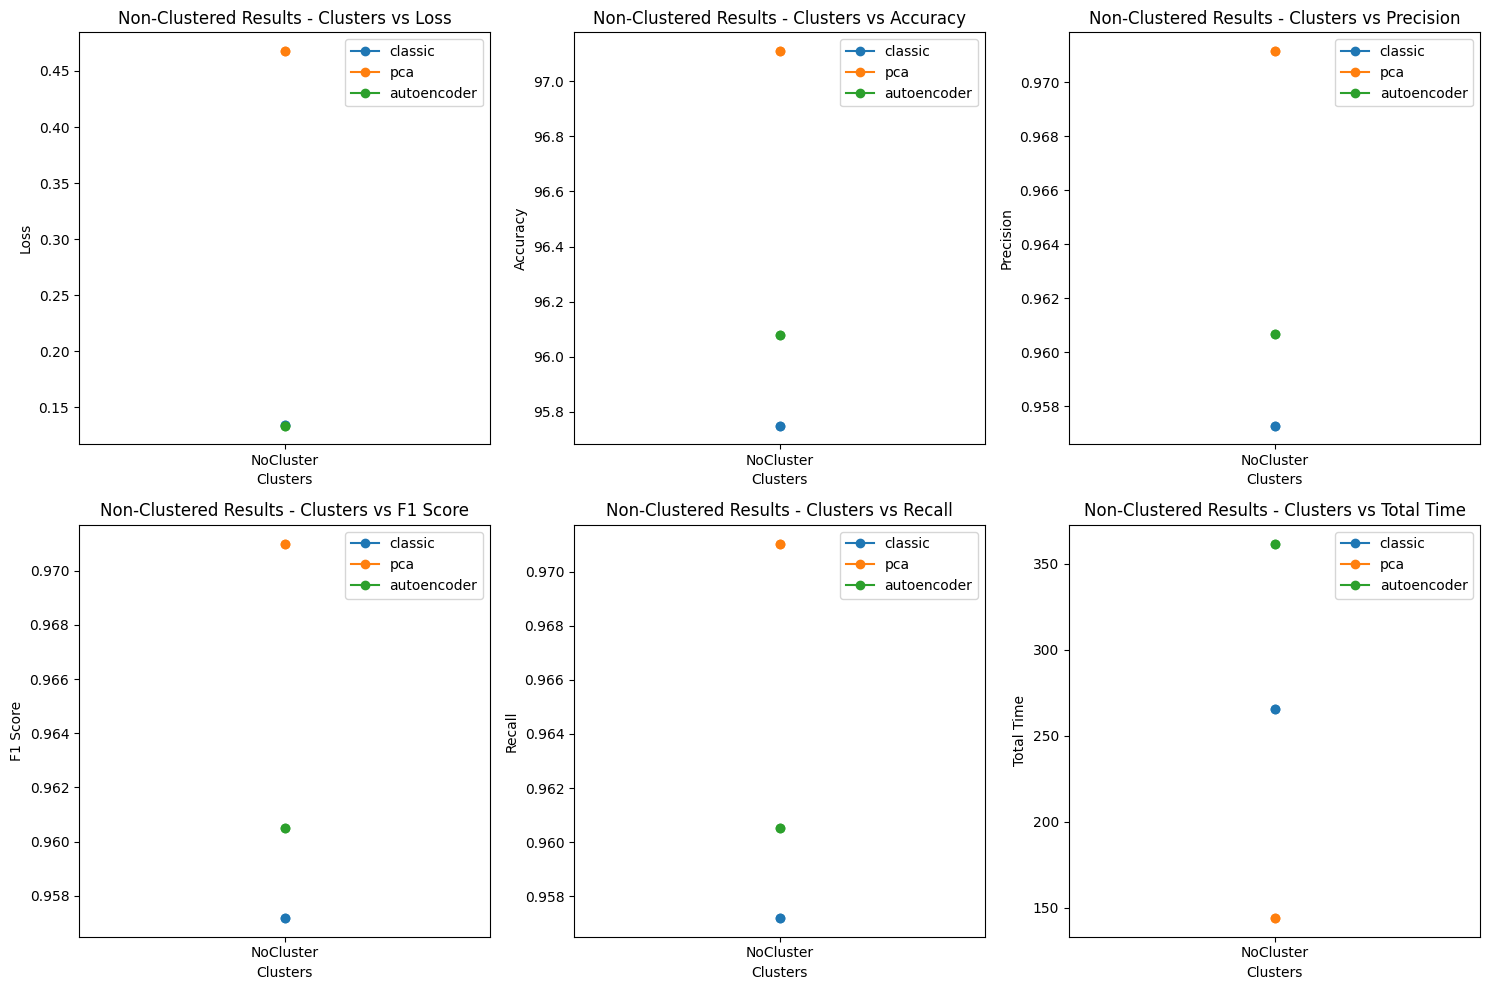


Clustered Results:
classic:
  Final Loss: {2: 0.04812007923126221, 4: 0.03998064956665039, 6: 0.03699978065490723, 8: 0.03528419437408447, 10: 0.034536015129089354}
  Final Accuracy: {2: 98.42, 4: 98.8, 6: 98.87, 8: 98.89, 10: 98.94}
  Final Precision: {2: 0.9842089101610426, 4: 0.9880000010020872, 6: 0.9887333015904402, 8: 0.9888855696260436, 10: 0.9894312580808858}
  Final F1 Score: {2: 0.9841343753151188, 4: 0.9879441458631092, 6: 0.9886442047858187, 8: 0.9888319444366533, 10: 0.9893627971858778}
  Final Recall: {2: 0.9841031264798271, 4: 0.9879145452620067, 6: 0.9885926869808541, 8: 0.9888111509906045, 10: 0.9893276513329836}
  Total Time: {2: 1042.5415015220642, 4: 1147.8886759281158, 6: 1127.9194297790527, 8: 1125.7170586585999, 10: 1152.615125656128}
pca:
  Final Loss: {2: 0.25686016845703125, 4: 0.20505394287109374, 6: 0.19606947479248046, 8: 0.17883182830810546, 10: 0.1794867645263672}
  Final Accuracy: {2: 98.01, 4: 98.16, 6: 98.11, 8: 98.18, 10: 98.17}
  Final Precision: {2

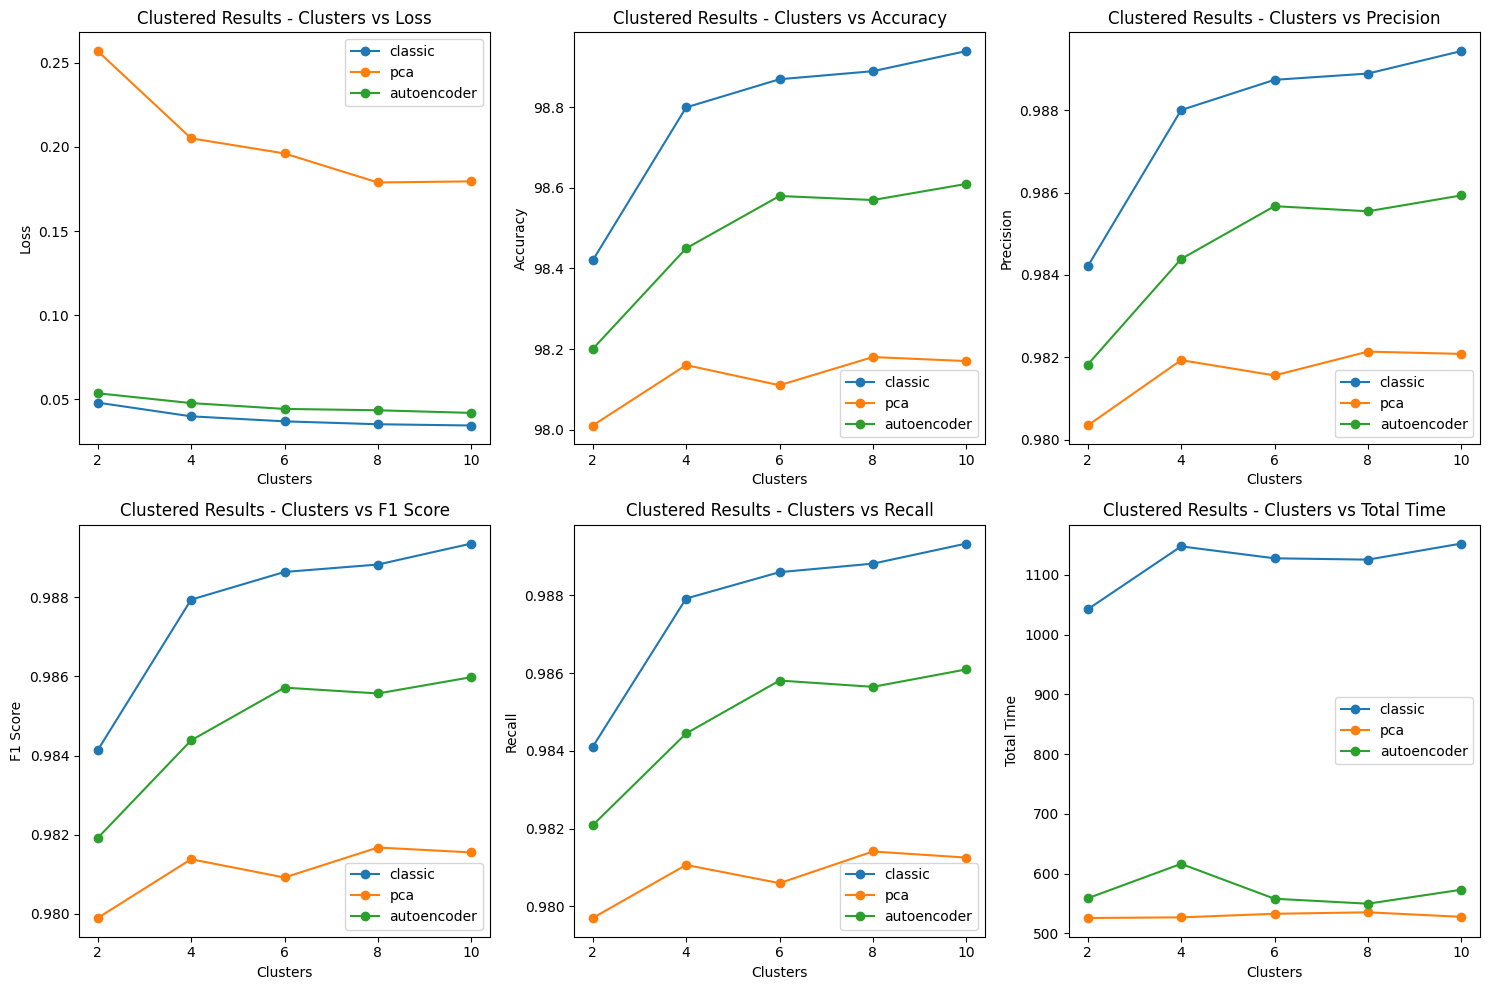

In [26]:
import numpy as np
import matplotlib.pyplot as plt

# Function to compute final metrics
def compute_final_metrics(metrics):
    final_loss = {alpha: data['losses'][-1] for alpha, data in metrics.items()}
    final_accuracy = {alpha: data['accuracy'][-1] for alpha, data in metrics.items()}
    final_precision = {alpha: data['precision'][-1] for alpha, data in metrics.items()}
    final_f1 = {alpha: data['f1'][-1] for alpha, data in metrics.items()}
    final_recall = {alpha: data['recall'][-1] for alpha, data in metrics.items()}

    # Sum of all training times
    total_time = {
        alpha: sum(data.get('TrainingTime', data.get('trainingTime', [0])))
        for alpha, data in metrics.items()
    }

    return final_loss, final_accuracy, final_precision, final_f1, final_recall, total_time

# Function to print results
def print_results(results, title):
    print(f"\n{title}:")
    for method in results.keys():
        final_loss, final_accuracy, final_precision, final_f1, final_recall, total_time = compute_final_metrics(results[method])
        print(f"{method}:")
        print("  Final Loss:", final_loss)
        print("  Final Accuracy:", final_accuracy)
        print("  Final Precision:", final_precision)
        print("  Final F1 Score:", final_f1)
        print("  Final Recall:", final_recall)
        print("  Total Time:", total_time)

# Function to plot the results
def plot_results(results, title, filename):
    plt.figure(figsize=(15, 10))

    # List of metrics to plot
    metrics_names = ["Loss", "Accuracy", "Precision", "F1 Score", "Recall", "Total Time"]
    for i, metric in enumerate(metrics_names):
        plt.subplot(2, 3, i + 1)

        # Plotting each method's metrics
        for method in results.keys():
            final_loss, final_accuracy, final_precision, final_f1, final_recall, total_time = compute_final_metrics(results[method])

            # Select the right metric based on the iteration
            metric_values = {
                "Loss": final_loss,
                "Accuracy": final_accuracy,
                "Precision": final_precision,
                "F1 Score": final_f1,
                "Recall": final_recall,
                "Total Time": total_time
            }[metric]

            # Plot the metric values for each method
            plt.plot(list(metric_values.keys()) + ['NoCluster'], list(metric_values.values()) + [metric_values.get('NoCluster', np.nan)], marker='o', label=method)

        plt.xlabel('Clusters')
        plt.ylabel(metric)
        plt.title(f'{title} - Clusters vs {metric}')
        plt.legend()

    # Adjust layout and save the plot
    plt.tight_layout()
    plt.savefig(filename)
    plt.show()

# Assuming 'results' and 'clusteredResults' are the data for the methods
# Print and plot results for non-clustered and clustered data

print_results(results, "Non-Clustered Results")
plot_results(results, "Non-Clustered Results", "non_clustered_results.png")

print_results(clusteredResults, "Clustered Results")
plot_results(clusteredResults, "Clustered Results", "clustered_results.png")
